<a href="https://colab.research.google.com/github/YTW0415/Kaggle_Basketball/blob/main/Kaggle_basket_20230313_final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset 불러오기 - 태원's github 주소에서 불러오는거니 실제 수상 시 없애고 자기 깃허브 주소로 변경 바랍니다

In [1]:
!git clone https://github.com/YTW0415/Kaggle_Basketball.git

Cloning into 'Kaggle_Basketball'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 76 (delta 16), reused 37 (delta 3), pack-reused 0
Unpacking objects: 100% (76/76), 30.29 MiB | 8.05 MiB/s, done.


# Adapting the 2nd Place Solution of the 2021 NCAAW Competition

- Solution write-up is available here : https://www.kaggle.com/c/ncaaw-march-mania-2021/discussion/230705
- 2nd place code : https://www.kaggle.com/theoviel/2nd-place-ncaaw-2021?scriptVersionId=58780991
- It was adapted from this notebook : https://www.kaggle.com/theoviel/ncaa-starter-the-simpler-the-better 

**Changes :**
- Build one model for both Men and Women
- Update metric to MSE

In [2]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [3]:
DATA_PATH = '/content/Kaggle_Basketball/march-machine-learning-mania-2023/'

for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

Cities.csv
Conferences.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv
SampleSubmission2023.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv
kenpom0823.csv


# Data preparation

## Seeds
> This file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday of the first week (by definition, that is DayNum=136 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 15, 2020 (DayNum=132).

> The seed is a 3/4-character :
- First character : Region (W, X, Y, or Z)
- Next two digits : Seed within the region (01 to 16)
- Last character (optional): Distinguishes teams between play-ins ( a or b)

In [4]:
df_seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)
    
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [5]:
df_seeds['Seed'].value_counts()

W01     61
X14     61
Y01     61
Y02     61
Y03     61
        ..
Z13a     1
Z13b     1
Y12a     1
Y12b     1
Z14b     1
Name: Seed, Length: 90, dtype: int64

## Conference

In [6]:
df_conference = pd.concat([
    pd.read_csv(DATA_PATH + "MTeamConferences.csv"),
    pd.read_csv(DATA_PATH + "WTeamConferences.csv"),
], ignore_index=True)
    
df_conference.head()

,Season,TeamID,ConfAbbrev
0,1985,1102,wac
1,1985,1103,ovc
2,1985,1104,sec
3,1985,1106,swac
4,1985,1108,swac


## Season results
> This file identifies the game-by-game results for many seasons of historical data, starting with the 1985 season (the first year the NCAA® had a 64-team tournament). For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

In [7]:
df_season_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv"),
], ignore_index=True)

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [8]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [9]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12


### Features 
For each team at each season, I compute : 
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses

And use the following features : 
- Win Ratio
- Average score gap

In [10]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [11]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [12]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [13]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

Merge

In [14]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [15]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [16]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [17]:
df_features_season.fillna(0, inplace=True)  

In [18]:
df_features_season = df_features_season.groupby(['TeamID','Season'])[df_features_season.columns[2:]].mean().reset_index()

In [19]:
df_features_season_3year = df_features_season.sort_values('Season').groupby(['TeamID'])[df_features_season.columns[2:]].rolling(3).mean().reset_index()

df_features_season_3year = df_features_season_3year[['NumWins','NumLosses','GapWins','GapLosses']]

df_features_season_3year.columns = df_features_season_3year.columns + '_3years'

df_features_season = pd.concat([df_features_season,df_features_season_3year],axis=1)

df_features_season.loc[df_features_season['NumWins_3years'].isnull(), df_features_season_3year.columns] = df_features_season.loc[df_features_season['NumWins_3years'].isnull(),df_features_season.iloc[:,2:6].columns].values

### Seed count add (0307)

In [20]:
df_features_season = df_features_season.merge(df_seeds, on=['Season', 'TeamID'], how='left').fillna('X0')

In [21]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df_features_season['Seed'] = df_features_season['Seed'].apply(treat_seed)

In [22]:
# # Adding 1 to each season and averaging can help you find the number of seeds and tournament appearances over 5 years as of last year

# df_features_seed_3year = df_features_season.copy()

# df_features_seed_3year.loc[df_features_seed_3year['Seed'] > 0,'TourneyY'] = 1

# df_features_seed_3year.loc[df_features_seed_3year['Seed'] == 0,'TourneyY'] = 0

# df_features_seed_3year['Season'] = df_features_seed_3year['Season'] + 1

# df_features_seed_3year_1 = df_features_seed_3year.sort_values('Season').groupby(['TeamID'])['TourneyY'].rolling(3).sum().fillna(method='bfill').reset_index()

# # df_features_seed_3year_2 = df_features_seed_3year.sort_values('Season').groupby(['TeamID'])['Seed'].rolling(3).mean().fillna(method='bfill').reset_index()

# # df_features_seed_3year = pd.concat([df_features_seed_3year_1,df_features_seed_3year_2],axis=1)

# df_features_seed_3year_1.columns = df_features_seed_3year_1.columns + '_3years'

# df_features_seed_3year = df_features_seed_3year_1['TourneyY_3years']

# df_features_season = pd.concat([df_features_season,df_features_seed_3year],axis=1)

# #Three years of missing values based on the data start year, and new teams may also be missing. 
# #The new team wants to fill the missing values with zero and set the learning period to start in 2001.

# df_features_season.loc[df_features_season['TourneyY_3years'].isnull(), 'TourneyY_3years'] = 0

3년 동안 Seed 3 내에 들어온 팀의 경우 TopClass team으로 분류합니다

In [23]:
# Adding 1 to each season and averaging can help you find the number of seeds and tournament appearances over 5 years as of last year

df_features_seed_3year = df_features_season.copy()

df_features_seed_3year.loc[df_features_seed_3year['Seed'] > 0,'TourneyY'] = 1

df_features_seed_3year.loc[df_features_seed_3year['Seed'] == 0,'TourneyY'] = 0

df_features_seed_3year.loc[df_features_seed_3year['Seed'] < 3,'TopClassY'] = 1

df_features_seed_3year.loc[df_features_seed_3year['Seed'] == 0,'TopClassY'] = 0

df_features_seed_3year['Season'] = df_features_seed_3year['Season'] + 1

df_features_seed_3year_1 = df_features_seed_3year.sort_values('Season').groupby(['TeamID'])['TourneyY'].rolling(3).sum().fillna(method='bfill').reset_index()

df_features_seed_3year_2 = df_features_seed_3year.sort_values('Season').groupby(['TeamID'])['TopClassY'].rolling(3).sum().fillna(method='bfill').reset_index()

df_features_seed_3year = pd.concat([df_features_seed_3year_1,df_features_seed_3year_2],axis=1)

df_features_seed_3year.columns = df_features_seed_3year.columns + '_3years'

df_features_seed_3year = df_features_seed_3year[['TourneyY_3years','TopClassY_3years']]

df_features_season = pd.concat([df_features_season,df_features_seed_3year],axis=1)

#Three years of missing values based on the data start year, and new teams may also be missing. 
#The new team wants to fill the missing values with zero and set the learning period to start in 2001.

df_features_season.loc[df_features_season['TourneyY_3years'].isnull(), 'TourneyY_3years'] = 0

df_features_season.loc[df_features_season['TopClassY_3years'].isnull(), 'TopClassY_3years'] = 0

Compute features

In [24]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)



In [25]:
df_features_season['WinRatio_3years'] = df_features_season['NumWins_3years'] / (df_features_season['NumWins_3years'] + df_features_season['NumLosses_3years'])
df_features_season['GapAvg_3years'] = (
    (df_features_season['NumWins_3years'] * df_features_season['GapWins_3years'] - 
    df_features_season['NumLosses_3years'] * df_features_season['GapLosses_3years'])
    / (df_features_season['NumWins_3years'] + df_features_season['NumLosses_3years'])
)

In [26]:
# df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

df_features_season.drop(df_features_season_3year.columns, axis=1, inplace=True)

In [27]:
df_features_season[df_features_season['Season'] == 2023].sort_values(by='WinRatio')

,TeamID,Season,NumWins,NumLosses,GapWins,GapLosses,Seed,TourneyY_3years,TopClassY_3years,WinRatio,GapAvg,WinRatio_3years,GapAvg_3years
19573,3389,2023,0.0,26.0,0.000000,20.423077,0,0.0,0.0,0.000000,-20.423077,0.305882,-8.948389
15380,3216,2023,0.0,24.0,0.000000,28.291667,0,0.0,0.0,0.000000,-28.291667,0.106061,-19.665010
17383,3298,2023,1.0,25.0,20.000000,19.520000,0,0.0,0.0,0.038462,-18.000000,0.231884,-8.021983
5276,1254,2023,1.0,24.0,4.000000,18.750000,0,0.0,0.0,0.040000,-17.840000,0.347222,-6.017802
21423,3473,2023,1.0,22.0,9.000000,19.318182,0,0.0,0.0,0.043478,-18.086957,0.043478,-18.086957
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20468,3424,2023,24.0,2.0,16.666667,16.000000,0,1.0,0.0,0.923077,14.153846,0.792683,8.934282
4161,1222,2023,25.0,2.0,21.760000,3.500000,0,2.0,0.0,0.925926,19.888889,0.885057,18.221836
16493,3261,2023,25.0,1.0,30.640000,24.000000,0,1.0,0.0,0.961538,28.538462,0.756410,10.313114
15741,3231,2023,26.0,1.0,22.153846,5.000000,0,2.0,0.0,0.962963,21.148148,0.825000,15.293974


## Season Results - detail

- WFGM - field goals made (by the winning team)
- WFGA - field goals attempted (by the winning team)
- WFGM3 - three pointers made (by the winning team)
- WFGA3 - three pointers attempted (by the winning team)
- WTO - turnovers committed (by the winning team)
- WFTM - free throws made (by the winning team)
- WFTA - free throws attempted (by the winning team)
- WOR - offensive rebounds (pulled by the winning team)
- Possessions per game = Field goals attempted - offensive rebounds + turnovers + 0.475 x free throws attempted
---

- WDR - defensive rebounds (pulled by the winning team)
- WAst - assists (by the winning team)
- WStl - steals (accomplished by the winning team)
- WBlk - blocks (accomplished by the winning team)
- WPF - personal fouls committed (by the winning team)

In [28]:
regseason_detail_df = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

regseason_detail_df.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [29]:
win_team_only = regseason_detail_df.drop(['WAst','LAst','LStl','WStl','LBlk','WBlk','LPF','WPF','DayNum'], axis=1)
win_team_only.rename(columns={'WTeamName': 'TeamName'}, inplace=True)
win_team_only.rename(columns={'WTeamID': 'TeamID'}, inplace=True)
win_team_only.rename(columns={'LTeamID': 'OpponentTeamID'}, inplace=True)

team_factors_list = ['Score','FGM','FGA','FGA3','FGM3','TO','FTM','FTA','RankPOM','OR']
for factor in team_factors_list:
    win_team_only.rename(columns={'W'+factor: factor}, inplace=True)
    win_team_only.rename(columns={'L'+factor: 'Opponent'+factor}, inplace=True)

win_team_only['wins'] = 1 

win_team_only = win_team_only[['Season','TeamID','wins','Score','OpponentScore',
                               'FGM','FGA','OpponentFGM','OpponentFGA','FGM3','FGA3',
                               'OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM',
                               'OpponentFTA','TO','OpponentTO',
                               'OR','OpponentOR','OpponentTeamID']]

In [30]:
loss_team_only = regseason_detail_df.drop(['WAst','LAst','LStl','WStl','LBlk','WBlk','LPF','WPF','DayNum'], axis=1)
loss_team_only.rename(columns={'LTeamName': 'TeamName'}, inplace=True)
loss_team_only.rename(columns={'LTeamID': 'TeamID'}, inplace=True)
loss_team_only.rename(columns={'WTeamID': 'OpponentTeamID'}, inplace=True)

for factor in team_factors_list:
    loss_team_only.rename(columns={'L'+factor: factor}, inplace=True)
    loss_team_only.rename(columns={'W'+factor: 'Opponent'+factor}, inplace=True)

loss_team_only['wins'] = 0

loss_team_only = loss_team_only[['Season','TeamID','wins','Score','OpponentScore',
                               'FGM','FGA','OpponentFGM','OpponentFGA','FGM3','FGA3',
                               'OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM',
                               'OpponentFTA','TO','OpponentTO',
                               'OR','OpponentOR','OpponentTeamID']]

In [31]:
reg_season_all = win_team_only.append(loss_team_only)

In [32]:
reg_season_all['TOmargin'] = reg_season_all['TO']-reg_season_all['OpponentTO']

reg_season_all['FG'] = reg_season_all['FGM']/reg_season_all['FGA']
reg_season_all['FGopponent'] = reg_season_all['OpponentFGM']/reg_season_all['OpponentFGA']

reg_season_all['FG3'] = reg_season_all['FGM3']/reg_season_all['FGA3']
reg_season_all['FG3opponent'] = reg_season_all['OpponentFGM3']/reg_season_all['OpponentFGA3']

reg_season_all['FT'] = reg_season_all['FTM']/reg_season_all['FTA']

reg_season_all['Possession'] = (reg_season_all['FGA'] -reg_season_all['OR'] +reg_season_all['TO'] + reg_season_all['FTA'] * 0.44) *0.96

reg_season_all['Possessionopponent'] = (reg_season_all['OpponentFGA'] -reg_season_all['OpponentOR'] +reg_season_all['OpponentTO'] + reg_season_all['OpponentFTA'] * 0.44)  *0.96

In [33]:
pd.options.display.float_format = '{:.2f}'.format

reg_season_all.corr()['wins'].sort_values()

OpponentScore        -0.49
FGopponent           -0.48
OpponentFGM          -0.40
FG3opponent          -0.30
OpponentFTM          -0.30
TOmargin             -0.28
OpponentFTA          -0.27
OpponentFGM3         -0.19
TO                   -0.17
FGA3                 -0.04
Possession           -0.02
OpponentOR           -0.02
FGA                  -0.02
OpponentTeamID       -0.00
Season                0.00
TeamID                0.00
OpponentFGA           0.02
OR                    0.02
Possessionopponent    0.02
OpponentFGA3          0.04
FT                    0.14
OpponentTO            0.17
FGM3                  0.19
FTA                   0.27
FTM                   0.30
FG3                   0.30
FGM                   0.40
FG                    0.48
Score                 0.49
wins                  1.00
Name: wins, dtype: float64

In [34]:
# 쓸모없는 것 드랍

reg_season_all = reg_season_all.drop(['TO','OpponentTO','FGM','FGA','OpponentFGA','OpponentFGM','FGM3','FGA3','OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM','OpponentFTA'], axis=1)

In [35]:
reg_season_all = reg_season_all.merge(reg_season_all.groupby(['TeamID','Season'])['Possession'].mean().reset_index(),
                                      on=['Season', 'TeamID'],
                                      suffixes=('', '_Average'))

#팀이 평균적으로 Possessionopponent를 얼마나 허용하는지
reg_season_all = reg_season_all.merge(reg_season_all.groupby(['OpponentTeamID','Season'])['Possessionopponent'].mean().reset_index(),
                                                              on=['OpponentTeamID', 'Season'],
                                                              suffixes=('', '_Average'))

### KenPom Score 추가
1. 1번 방법
- Adjusted Offensive Efficiency : (Points Scored / Possessions) * (Opponent Average Possessions / 100)
- Adjusted Defensive Efficiency = (Points Allowed / Possessions) * (Opponent Average Possessions / 100)
- Adjusted Efficiency Margin = Adjusted Offensive Efficiency - Adjusted Defensive Efficiency
- Expected Winning Percentage = (Adjusted Offensive Efficiency ^ 11.5) / [(Adjusted Offensive Efficiency ^ 11.5) + (Adjusted Defensive Efficiency ^ 11.5)]

2. 일반적인 방법
- Offensive Efficiency : (Points Scored / Possessions)
- Defensive Efficiency = (Points Allowed / Possessions)
- Efficiency Margin = Offensive Efficiency - Defensive Efficiency
- Expected Winning Percentage = (Points Scored)16.5/[Points Scored)16.5 + (Points Allowed)16.5)]


In [36]:
reg_season_all['AdjO'] = reg_season_all['Score'] / reg_season_all['Possession'] * 100 * reg_season_all['Possessionopponent'] / 100 

reg_season_all['AdjD'] = reg_season_all['OpponentScore'] / reg_season_all['Possession'] * 100 * reg_season_all['Possessionopponent'] / 100 

reg_season_all['AdjEM'] = reg_season_all['AdjO']  - reg_season_all['AdjD'] 


reg_season_all['AdjEWP'] = reg_season_all['AdjO'] ** 11.5  / (reg_season_all['AdjO'] **11.5 + reg_season_all['AdjD']**11.5)

reg_season_all['OE'] = reg_season_all['Score'] / reg_season_all['Possession'] * 100

reg_season_all['DE'] = reg_season_all['OpponentScore'] / reg_season_all['Possession'] * 100

reg_season_all['EM'] = reg_season_all['OE']  - reg_season_all['DE'] 

reg_season_all['EWP'] = reg_season_all['Score']**16.5 /(reg_season_all['Score']**16.5  + reg_season_all['OpponentScore']**16.5) 

In [37]:
reg_season_all = reg_season_all.drop('OpponentTeamID',axis=1)

In [38]:
reg_season_all.columns

Index(['Season', 'TeamID', 'wins', 'Score', 'OpponentScore', 'OR',
       'OpponentOR', 'TOmargin', 'FG', 'FGopponent', 'FG3', 'FG3opponent',
       'FT', 'Possession', 'Possessionopponent', 'Possession_Average',
       'Possessionopponent_Average', 'AdjO', 'AdjD', 'AdjEM', 'AdjEWP', 'OE',
       'DE', 'EM', 'EWP'],
      dtype='object')

In [39]:
reg_season_means = reg_season_all.groupby(['TeamID','Season']).mean().reset_index()

In [40]:
reg_season_means = reg_season_means.drop(['wins'], axis=1)

In [41]:
reg_season_sum = reg_season_all.groupby(['TeamID','Season']).sum().reset_index()

In [42]:
reg_season_sum = reg_season_sum.drop(['Score','OpponentScore','TOmargin','FG','FG3','FGopponent','FG3opponent','FT',
                                      'OR','OpponentOR',
                                      'Possession','Possessionopponent','Possession_Average','Possessionopponent_Average',
                                      'AdjO','AdjD','AdjEM','AdjEWP',
                                      'OE','DE','EM','EWP'], axis=1)

In [43]:
regseason_df = pd.merge(reg_season_means, reg_season_sum, left_on=['TeamID','Season'], right_on = ['TeamID','Season'], how='left')

In [44]:
regseason_df.head()

,TeamID,Season,Score,OpponentScore,OR,OpponentOR,TOmargin,FG,FGopponent,FG3,FG3opponent,FT,Possession,Possessionopponent,Possession_Average,Possessionopponent_Average,AdjO,AdjD,AdjEM,AdjEWP,OE,DE,EM,EWP,wins
0,1101,2014,63.14,78.62,8.00,10.38,2.86,0.41,0.51,0.38,0.37,0.76,63.81,63.88,63.81,65.24,63.10,78.77,-15.66,0.18,98.50,123.51,-25.01,0.15,2
1,1101,2015,61.00,71.86,8.25,10.04,-0.64,0.41,0.49,0.38,0.37,0.74,61.52,61.71,61.52,63.58,61.23,72.14,-10.90,0.29,98.38,117.03,-18.65,0.28,7
2,1101,2016,69.85,76.26,8.19,8.59,-0.04,0.44,0.49,0.36,0.37,0.70,65.97,66.72,65.97,67.35,70.74,77.16,-6.42,0.37,105.66,115.74,-10.07,0.36,9
3,1101,2017,67.88,72.64,7.56,10.64,-0.32,0.46,0.46,0.37,0.35,0.64,65.67,65.58,65.67,67.41,67.81,72.55,-4.74,0.38,103.28,110.64,-7.36,0.37,9
4,1101,2018,70.67,72.81,9.04,9.93,-1.07,0.45,0.46,0.33,0.32,0.71,67.26,67.36,67.26,67.91,70.77,72.91,-2.14,0.45,105.34,108.52,-3.18,0.45,12


## Tourney results

> This file identifies the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the MRegularSeasonCompactResults data. All games will show up as neutral site (so WLoc is always N). Note that this tournament game data also includes the play-in games (which always occurred on day 134/135) for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

In [45]:
df_tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv"),
    pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv"),
], ignore_index=True)
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [46]:
df_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,137,3104,94,3422,46
1,1998,137,3112,75,3365,63
2,1998,137,3163,93,3193,52
3,1998,137,3198,59,3266,45
4,1998,137,3203,74,3208,72
...,...,...,...,...,...,...
3895,2022,146,1242,76,1274,50
3896,2022,146,1314,69,1389,49
3897,2022,152,1242,81,1437,65
3898,2022,152,1314,81,1181,77


## FiveThirtyEight Ratings
> Not available yet !

In [47]:
# df_538 = pd.read_csv("../input/ncaa-men-538-team-ratings/538ratingsMen.csv")
# df_538.drop('TeamName', axis=1, inplace=True)
# df_538.head()

## Kenpom

Kenpom 정보를 크롤링했으나 남자팀만 존재하여 실제로는 Kenpom의 공식에 따라 값을 구하였음. 구하는 방법이 일부 틀릴 수 있음 (특히 Lucky)

https://github.com/harmkenn/Python_Madness_2023/blob/58ed1e5876817bf4e65ba4bf05b59fb3fa1e4cfd/notebooks/step01_aScrapeKenPom.ipynb

In [48]:
# # Grab KenPom 2008 to 2022

# from urllib.request import Request, urlopen
# from bs4 import BeautifulSoup
# import pandas as pd
# import numpy as np
# from tqdm import tqdm

# season = np.arange(2008,2023,1)
# allkp = pd.DataFrame(columns = ['Year','Team','Conf','AdjEM','AdjO','AdjD','AdjT','SOSEM','SOSO','SOSD'])
# for y in season:
#     req = Request(
#         url=f'https://kenpom.com/index.php?y={y}', 
#         headers={'User-Agent': 'Mozilla/5.0'}
#     )
#     webpage = urlopen(req).read()
#     soup =BeautifulSoup(webpage, 'html.parser')

#     table = soup.find('table', class_=None)
    
#     for row in tqdm(table.tbody.find_all('tr')):    
#         # Find all data for each column
#         columns = row.find_all('td')
        
#         if(columns != []):
            
#             Team = columns[1].text.strip()
#             Conf = columns[2].text.strip()
            
#             AdjEM = columns[4].text.strip()
#             AdjO = columns[5].text.strip()
#             AdjD = columns[7].text.strip()
#             AdjT = columns[9].text.strip()
#             SOSEM = columns[13].text.strip()
#             SOSO = columns[15].text.strip()
#             SOSD = columns[17].text.strip()
#             newrow = [y,Team,Conf,AdjEM,AdjO,AdjD,AdjT,SOSEM,SOSO,SOSD]
#             allkp.loc[len(allkp)]=newrow
#             #newrow = pd.DataFrame({'Year':2008,'Team': Team,'Conf':Conf,'AdjEM':AdjEM,'AdjO':AdjO,'AdjD':AdjD,'AdjT':AdjT,'SOSEM':SOSEM,'SOSO':SOSO,'SOSD':SOSD})
#             #allkp = pd.concat(allkp,newrow)
#             allkp['Team'] = allkp['Team'].str.replace('\d+','',regex=True).str.replace('*','',regex=True).str.rstrip()

# allkp.to_csv('step01_kenpom0823.csv',index=False)

In [49]:
# # Grab KenPom 2023

# from urllib.request import Request, urlopen
# from bs4 import BeautifulSoup
# import pandas as pd
# import numpy as np


# allkp = pd.read_csv('step01_kenpom0823.csv')
# allkp = allkp[allkp['Year']!=2023]
# y = 2023

# req = Request(
#     url=f'https://kenpom.com/index.php?y={y}', 
#     headers={'User-Agent': 'Mozilla/5.0'}
# )
# webpage = urlopen(req).read()
# soup =BeautifulSoup(webpage, 'html.parser')

# table = soup.find('table', class_=None)

# for row in table.tbody.find_all('tr'):    
#     # Find all data for each column
#     columns = row.find_all('td')
    
#     if(columns != []):
        
#         Team = columns[1].text.strip()
#         Conf = columns[2].text.strip()
        
#         AdjEM = columns[4].text.strip()
#         AdjO = columns[5].text.strip()
#         AdjD = columns[7].text.strip()
#         AdjT = columns[9].text.strip()
#         SOSEM = columns[13].text.strip()
#         SOSO = columns[15].text.strip()
#         SOSD = columns[17].text.strip()
#         newrow = [y,Team,Conf,AdjEM,AdjO,AdjD,AdjT,SOSEM,SOSO,SOSD]
#         allkp.loc[len(allkp)]=newrow
#         #newrow = pd.DataFrame({'Year':2008,'Team': Team,'Conf':Conf,'AdjEM':AdjEM,'AdjO':AdjO,'AdjD':AdjD,'AdjT':AdjT,'SOSEM':SOSEM,'SOSO':SOSO,'SOSD':SOSD})
#         #allkp = pd.concat(allkp,newrow)
#         allkp['Team'] = allkp['Team'].str.replace('\d+','',regex=True).str.replace('*','',regex=True).str.rstrip()


# allkp.to_csv('step01_kenpom0823.csv',index=False)

# Feature Engineering

## Train data

In [50]:
# 여자부의 능력치가 있는 2013년 이후를 대상으로 모델 만들기

df = df_tourney_results.copy()
df = df[df['Season'] >= 2001].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2001,137,3155,51,3151,49
1,2001,137,3196,84,3221,52
2,2001,137,3199,72,3408,70
3,2001,137,3208,77,3251,48
4,2001,137,3235,100,3224,61


### Seeds
- `SeedW` is the seed of the winning team
- `SeedL` is the seed of the losing team

In [51]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [52]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [53]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [54]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2001,137,3155,51,3151,49,5,12
1,2001,137,3196,84,3221,52,3,14
2,2001,137,3199,72,3408,70,7,10
3,2001,137,3208,77,3251,48,2,15
4,2001,137,3235,100,3224,61,2,15


### Season Stats
- `WinRatioW` is the win ratio of the winning team during the season
- `WinRatioL` is the win ratio of the losing team during the season

In [55]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
    'WinRatio_3years': 'WinRatio_3yearsW',
    'GapAvg_3years': 'GapAvg_3yearsW',
    'TourneyY_3years':'TourneyY_3yearsW',
    'TopClassY_3years':'TopClassY_3yearsW',
}).drop(columns='TeamID', axis=1)

In [56]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
    'WinRatio_3years': 'WinRatio_3yearsL',
    'GapAvg_3years': 'GapAvg_3yearsL',
    'TourneyY_3years':'TourneyY_3yearsL',
    'TopClassY_3years':'TopClassY_3yearsL',
}).drop(columns='TeamID', axis=1)

### Season Stats detail

In [57]:
df = pd.merge(
    df,
    regseason_df,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginW',
    'FG': 'FGW',
    'FGopponent': 'FGopponentW',
    'FG3': 'FG3W',
    'FG3opponent': 'FG3opponentW',
    'FT': 'FTW',
    'AdjO':'AdjOW',
    'AdjD':'AdjDW',
    'AdjEM':'AdjEMW',
    'AdjEWP':'AdjEWPW',
    'Possession':'PossessionW',
    'OE':'OEW',
    'DE':'DEW',
    'EM':'EMW',
    'EWP':'EWPW'
}).drop(columns='TeamID', axis=1)

In [58]:
df = pd.merge(
    df,
    regseason_df,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginL',
    'FG': 'FGL',
    'FGopponent': 'FGopponentL',
    'FG3': 'FG3L',
    'FG3opponent': 'FG3opponentL',
    'FT': 'FTL',
    'AdjO':'AdjOL',
    'AdjD':'AdjDL',
    'AdjEM':'AdjEML',
    'AdjEWP':'AdjEWPL',
    'EWP':'EWPL',
    'Possession':'PossessionL',
    'OE':'OEL',
    'DE':'DEL',
    'EM':'EML',
    'EWP':'EWPL'
}).drop(columns='TeamID', axis=1)

### FiveThirtyEight Ratings
- `538ratingW` is the rating of the winning team during the season
- `538ratingL` is the rating of the losing team during the season

In [59]:
# df = pd.merge(
#     df,
#     df_538,
#     how='left',
#     left_on=['Season', 'WTeamID'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingW'})

In [60]:
# df = pd.merge(
#     df, 
#     df_538, 
#     how='left', 
#     left_on=['Season', 'LTeamID'], 
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingL'})

In [61]:
# df.head()

### Add symetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [62]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)

In [63]:
df = add_loosing_matches(df)

### Differences
- We compute the difference between the team for each feature.
- This helps further assessing how better (or worse) team A is from team B

In [64]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', # '538rating'
    'FG','FG3','FT','TOmargin', # Custom stat
    'WinRatio_3years', 'GapAvg_3years','TourneyY_3years','TopClassY_3years',
    'AdjO','AdjD','AdjEM','AdjEWP',
    'OE','DE','EM','EWP',
    'Possession'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

In [65]:
df.columns

Index(['Season', 'DayNum', 'TeamIdA', 'ScoreA', 'TeamIdB', 'ScoreB', 'SeedA',
       'SeedB', 'NumWinsA', 'NumLossesA', 'GapWinsA', 'GapLossesA', 'Seed_x',
       'TourneyY_3yearsA', 'TopClassY_3yearsA', 'WinRatioA', 'GapAvgA',
       'WinRatio_3yearsA', 'GapAvg_3yearsA', 'NumWinsB', 'NumLossesB',
       'GapWinsB', 'GapLossesB', 'Seed_y', 'TourneyY_3yearsB',
       'TopClassY_3yearsB', 'WinRatioB', 'GapAvgB', 'WinRatio_3yearsB',
       'GapAvg_3yearsB', 'Score_x', 'OpponentScore_x', 'OR_x', 'OpponentOR_x',
       'TOmarginA', 'FGA', 'FGopponentA', 'FG3A', 'FG3opponentA', 'FTA',
       'PossessionA', 'Possessionopponent_x', 'Possession_Average_x',
       'Possessionopponent_Average_x', 'AdjOA', 'AdjDA', 'AdjEMA', 'AdjEWPA',
       'OEA', 'DEA', 'EMA', 'EWPA', 'wins_x', 'Score_y', 'OpponentScore_y',
       'OR_y', 'OpponentOR_y', 'TOmarginB', 'FGB', 'FGopponentB', 'FG3B',
       'FG3opponentB', 'FTB', 'PossessionB', 'Possessionopponent_y',
       'Possession_Average_y', 'Possessionoppon

## Test Data

### Preparing

In [66]:
df_test = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")

In [67]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [68]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.50,2023,1101,1102
1,2023_1101_1103,0.50,2023,1101,1103
2,2023_1101_1104,0.50,2023,1101,1104
3,2023_1101_1105,0.50,2023,1101,1105
4,2023_1101_1106,0.50,2023,1101,1106
...,...,...,...,...,...
130678,2023_3474_3476,0.50,2023,3474,3476
130679,2023_3474_3477,0.50,2023,3474,3477
130680,2023_3475_3476,0.50,2023,3475,3476
130681,2023_3475_3477,0.50,2023,3475,3477


### Seeds
- Seeds are not released yet, so I fill missing values with "W01"

In [69]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W01')

In [70]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W01')

In [71]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

### Season Stats

In [72]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
    'WinRatio_3years': 'WinRatio_3yearsA',
    'GapAvg_3years': 'GapAvg_3yearsA',
    'TourneyY_3years':'TourneyY_3yearsA',
    'TopClassY_3years':'TopClassY_3yearsA',
}).drop(columns='TeamID', axis=1)

In [73]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
    'WinRatio_3years': 'WinRatio_3yearsB',
    'GapAvg_3years': 'GapAvg_3yearsB',
    'TourneyY_3years':'TourneyY_3yearsB',
    'TopClassY_3years':'TopClassY_3yearsB',
}).drop(columns='TeamID', axis=1)

#### Season detail

In [74]:
df_test = pd.merge(
    df_test,
    regseason_df,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginA',
    'FG': 'FGA',
    'FGopponent': 'FGopponentA',
    'FG3': 'FG3A',
    'FG3opponent': 'FG3opponentA',
    'FT': 'FTA',
    'AdjO':'AdjOA',
    'AdjD':'AdjDA',
    'AdjEM':'AdjEMA',
    'AdjEWP':'AdjEWPA',
    'Possession':'PossessionA',
    'OE':'OEA',
    'DE':'DEA',
    'EM':'EMA',
    'EWP':'EWPA'
}).drop(columns='TeamID', axis=1)

In [75]:
df_test = pd.merge(
    df_test,
    regseason_df,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginB',
    'FG': 'FGB',
    'FGopponent': 'FGopponentB',
    'FG3': 'FG3B',
    'FG3opponent': 'FG3opponentB',
    'FT': 'FTB',
    'AdjO':'AdjOB',
    'AdjD':'AdjDB',
    'AdjEM':'AdjEMB',
    'AdjEWP':'AdjEWPB',
    'Possession':'PossessionB',
    'OE':'OEB',
    'DE':'DEB',
    'EM':'EMB',
    'EWP':'EWPB'
}).drop(columns='TeamID', axis=1)

### Ratings

In [76]:
# df_test = pd.merge(
#     df_test,
#     df_538,
#     how='left',
#     left_on=['Season', 'TeamIdA'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingA'})

In [77]:
# df_test = pd.merge(
#     df_test,
#     df_538,
#     how='left',
#     left_on=['Season', 'TeamIdB'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingB'})

### Differences

In [78]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

## Target

In [79]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

In [80]:
df['LuckyA'] = df['WinRatioA'] - df['EWPA']

df['LuckyB'] = df['WinRatioB'] - df['EWPB']

df['LuckyDiff'] = df['LuckyA'] -df['LuckyB']

In [81]:
df_test['LuckyA'] = df_test['WinRatioA'] - df_test['EWPA']

df_test['LuckyB'] = df_test['WinRatioB'] - df_test['EWPB']

df_test['LuckyDiff'] = df_test['LuckyA'] -df_test['LuckyB']

### EDA

<AxesSubplot:xlabel='SeedA', ylabel='WinRatio_3yearsA'>

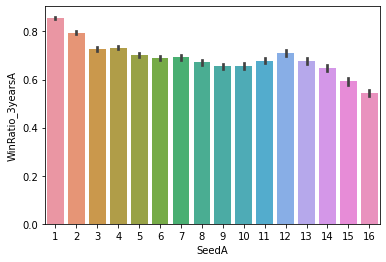

In [82]:
sns.barplot(x= 'SeedA',
            y='WinRatio_3yearsA',
            data = df,
            )

<AxesSubplot:xlabel='SeedA', ylabel='TourneyY_3yearsA'>

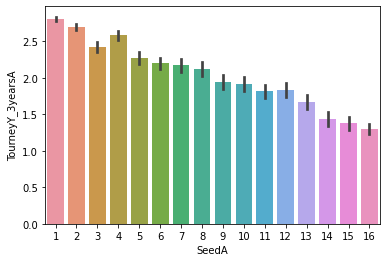

In [83]:
sns.barplot(x= 'SeedA',
            y='TourneyY_3yearsA',
            data = df,
            )

<AxesSubplot:xlabel='SeedA', ylabel='TopClassY_3yearsA'>

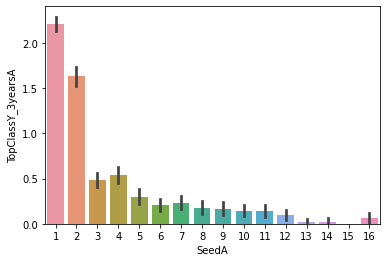

In [84]:
sns.barplot(x= 'SeedA',
            y='TopClassY_3yearsA',
            data = df,
            )

<AxesSubplot:xlabel='TopClassY_3yearsDiff', ylabel='WinA'>

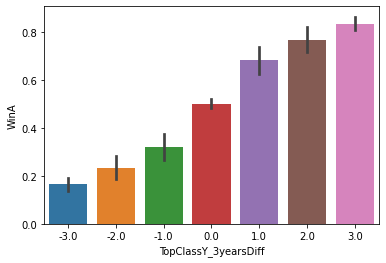

In [85]:
sns.barplot(x= 'TopClassY_3yearsDiff',
            y='WinA',
            data = df,
            )

<AxesSubplot:xlabel='TourneyY_3yearsDiff', ylabel='WinA'>

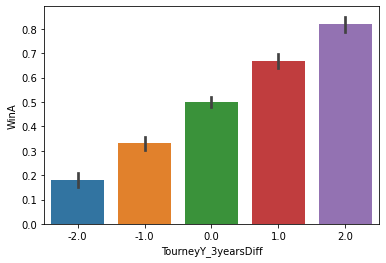

In [86]:
sns.barplot(x= 'TourneyY_3yearsDiff',
            y='WinA',
            data = df,
            )

# Modeling

#### Baseline

In [87]:
features = [
    'SeedA', 'SeedB',
    'SeedDiff',
    'WinRatioA', 'WinRatioB',
    'WinRatioDiff', 
    'GapAvgA', 'GapAvgB',
    'GapAvgDiff',
    #'FGDiff',
    #'FGA','FGB',
    #'FG3Diff',
    #'FG3A','FG3B',
    #'FTDiff',
    #'FTA','FTB',
    #'TOmarginDiff',
    #'TOmarginA','TOmarginB'
]

In [88]:
# A하고 B 둘 중에 하나만 들어가야할 것 같음. 둘이 사실상 같은 변수임임

features = [
    #'SeedA', #'SeedB',
    'SeedDiff',
    'WinRatioA', 'WinRatioB',
    'WinRatioDiff', 
    'GapAvgA', #'GapAvgB',
    'GapAvgDiff',
    'FGDiff',
    'FGA','FGB',
    'FG3Diff',
    'FG3A','FG3B',
    'FTDiff',
    'FTA','FTB',
    'TOmarginDiff',
    'TOmarginA','TOmarginB',
    'WinRatio_3yearsA', 'WinRatio_3yearsB',
    'WinRatio_3yearsDiff', 
    'GapAvg_3yearsA', 'GapAvg_3yearsB',
    'GapAvg_3yearsDiff',
    'AdjOA','AdjOB',
    'AdjODiff',
    'AdjDA', 'AdjDB',
    'AdjDDiff',
    'AdjEMA', 'AdjEMB',
    'AdjEMDiff',
    'LuckyA', 'LuckyB',
    'LuckyDiff',
    'TourneyY_3yearsA','TourneyY_3yearsB',
    'TourneyY_3yearsDiff',
    'TopClassY_3yearsDiff'
]

In [89]:
# A하고 B 둘 중에 하나만 들어가야할 것 같음. 둘이 사실상 같은 변수임임

features = [
    #'SeedA', 'SeedB',
    'SeedDiff',
    #'WinRatioA', 'WinRatioB',
    'WinRatioDiff', 
    #'GapAvgA', #'GapAvgB',
    'GapAvgDiff',
    'FGDiff',
    #'FGA','FGB',
    'FG3Diff',
    #'FG3A','FG3B',
    'FTDiff',
    #'FTA','FTB',
    'TOmarginDiff',
    #'TOmarginA','TOmarginB',
    #'WinRatio_3yearsA', 'WinRatio_3yearsB',
    'WinRatio_3yearsDiff', 
    #'GapAvg_3yearsA', 'GapAvg_3yearsB',
    'GapAvg_3yearsDiff',
    #'AdjOA','AdjOB',
    #'AdjODiff',
    #'AdjDA', 'AdjDB',
    #'AdjDDiff',
    #'AdjEMA', 'AdjEMB',
    #'AdjEMDiff',
    #'AdjEWPA','AdjEWPB',
    #'AdjEWPDiff',
    #'LuckyA', 'LuckyB',
    'LuckyDiff',
    'TourneyY_3yearsA','TourneyY_3yearsB',
    'TourneyY_3yearsDiff',
    #'OEA','OB',
    'OEDiff',
    #'DA', 'DB',
    'DEDiff',
    #'EMA', 'EMB',
    'EMDiff',
    #'EWPA','EWPB',
    'EWPDiff',
    'TopClassY_3yearsDiff',
]

In [90]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

### Cross Validation
- Validate on season `n`, for `n` in the 3 last seasons. 
- Train on earlier seasons. First available season is 2016 because of the FiveThirtyEight ratings.
- Pipeline support classification (predict the team that wins) and regression (predict the score gap), but classification worked better on CV.

### Baseline은 엘라스틱넷 회귀, 로지스틱 회귀

In [91]:
def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
#             model = LinearRegression()
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=1)

        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                
#                 print( pred_test.max() - pred_test.min())
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.title('Prediction vs Score Diff')
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred, bins=20)
            plt.title('Predictions probability repartition')
            plt.show()
        
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        pred = np.clip(pred, 0, 1)

        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        if verbose:
            print(f'\t -> Scored {score:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests, cvs


Validating on season 2014


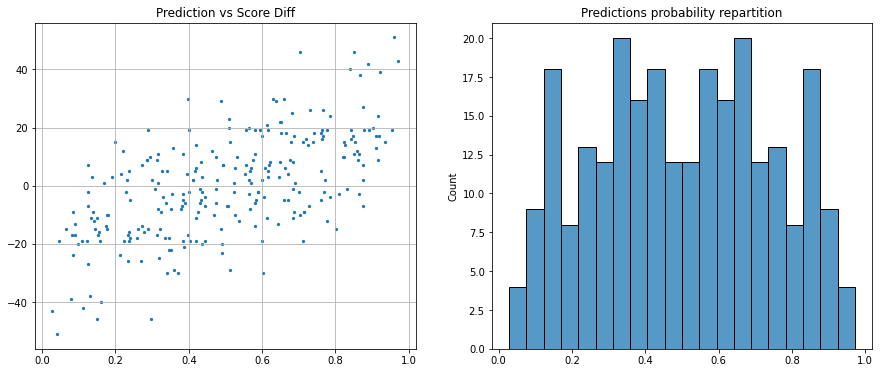

	 -> Scored 0.197

Validating on season 2015


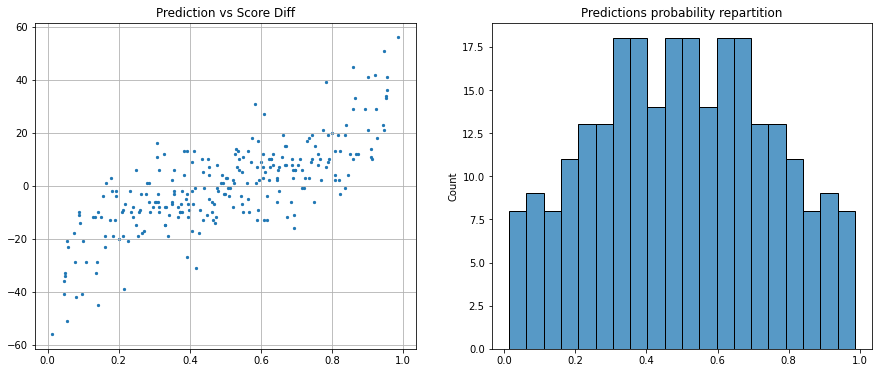

	 -> Scored 0.152

Validating on season 2016


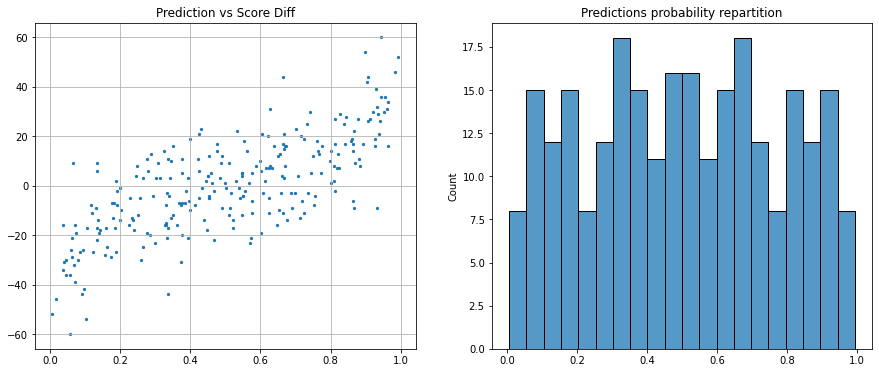

	 -> Scored 0.175

Validating on season 2017


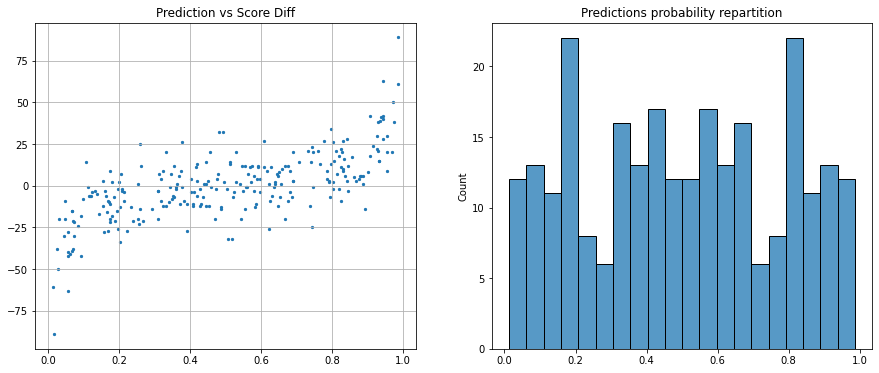

	 -> Scored 0.162

Validating on season 2018


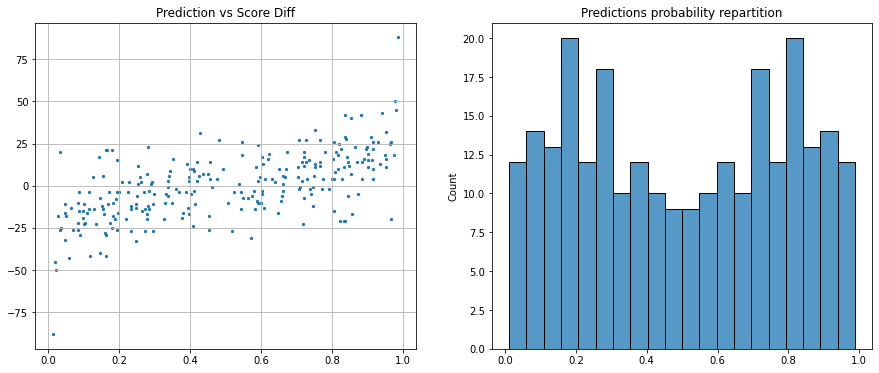

	 -> Scored 0.184

Validating on season 2019


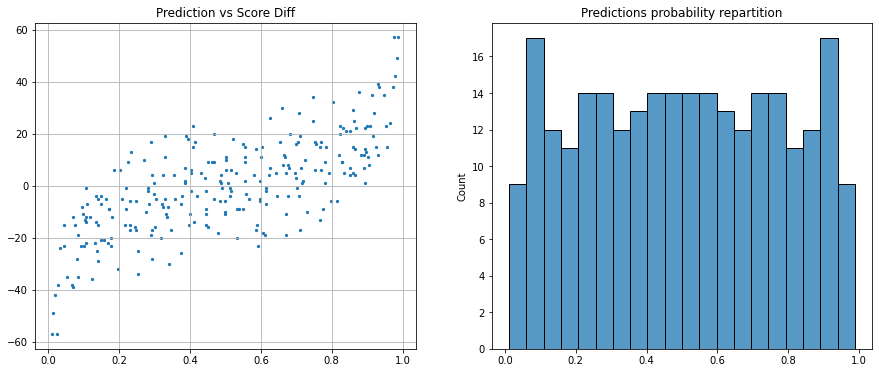

	 -> Scored 0.151

Validating on season 2021


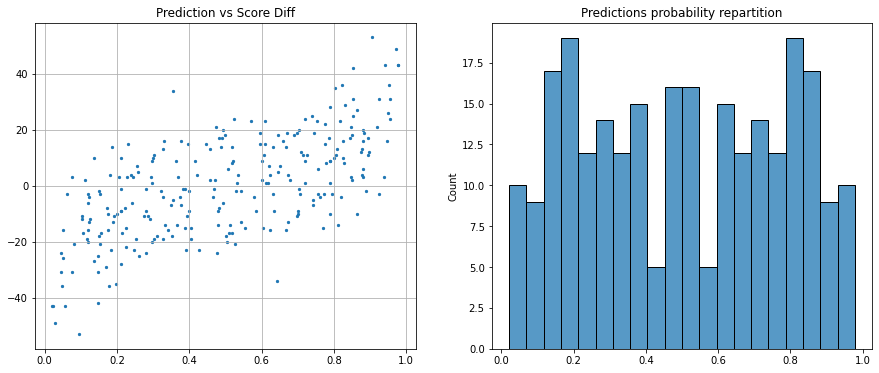

	 -> Scored 0.185

Validating on season 2022


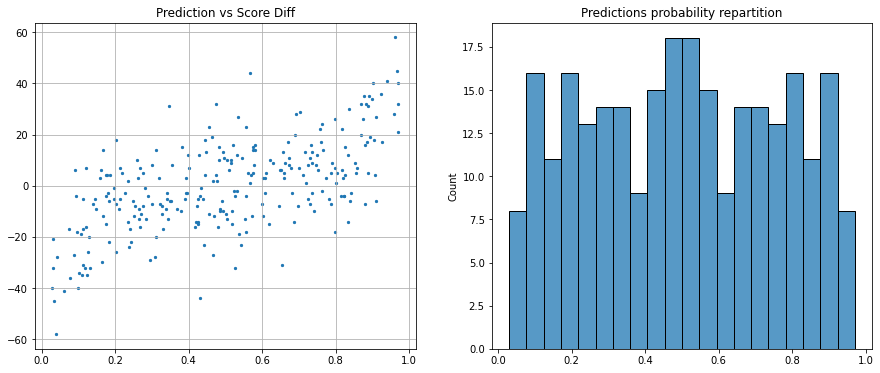

	 -> Scored 0.195

 Local CV is 0.175


In [92]:
pred_tests, cvs = kfold(df[df['Season'] >= 2013], df_test, plot=True, verbose=1, mode="cls")

## Submission

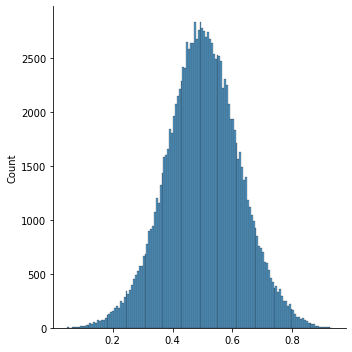

In [93]:
pred_test = np.mean(pred_tests, 0)
df_test['pred'] = pred_test

_ = sns.displot(pred_test)

In [94]:
final_sub = df_test[['ID', 'pred']].copy()
final_sub.to_csv('submission_baseline_0307.csv', index=False)

In [95]:
final_sub[final_sub['pred'] < 0.5]

,ID,pred
8,2023_1101_1111,0.49
9,2023_1101_1112,0.46
13,2023_1101_1116,0.43
16,2023_1101_1120,0.47
19,2023_1101_1124,0.39
...,...,...
130676,2023_3473_3477,0.38
130677,2023_3474_3475,0.33
130678,2023_3474_3476,0.41
130679,2023_3474_3477,0.40


Done ! 

# AutoML

여기서부터가 가져온 게 아니라 실제로 만든 것, AutoML로 모델 구축

In [1]:
!pip install --use-deprecated=legacy-resolver pycaret[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 78.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 KB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install numba==0.53

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
    Uninstalling llvmlite-0.37.0:
      Successfully uninstalled llvmlite-0.37.0
  Attempting uninstall: numba
    Found existing installation: numba 0.54.1
    Uninstalling numba-0.54.1:
      Successfully uninstalled numba-0.54.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainerdashboard 0.4.2.1 requires graphviz>=0.18.2, but you have graphviz 0.10.1 which is incompatible.
explainerdashboard 0.4.2.1 requires scikit-learn>=1.1, but you have scikit-learn 0.23.2 which is incompatible.


In [3]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.2 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==0.2 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.

#### Setup

In [96]:
train_df = pd.concat([df[df['Season'] >= 2013][features], df[df['Season'] >= 2013]['WinA']],axis=1)

test_df = df_test[features]

In [97]:
train_df.columns

Index(['SeedDiff', 'WinRatioDiff', 'GapAvgDiff', 'FGDiff', 'FG3Diff', 'FTDiff',
       'TOmarginDiff', 'WinRatio_3yearsDiff', 'GapAvg_3yearsDiff', 'LuckyDiff',
       'TourneyY_3yearsA', 'TourneyY_3yearsB', 'TourneyY_3yearsDiff', 'OEDiff',
       'DEDiff', 'EMDiff', 'EWPDiff', 'TopClassY_3yearsDiff', 'WinA'],
      dtype='object')

In [98]:
#Lucky이 상관계수는 낮은데 막상 모델에서 중요도가 좋게 나올때가 존재했음

train_df.corr()['WinA'].sort_values()

SeedDiff               -0.52
DEDiff                 -0.26
TourneyY_3yearsB       -0.24
TOmarginDiff           -0.14
LuckyDiff              -0.04
FTDiff                  0.09
FG3Diff                 0.18
TourneyY_3yearsA        0.24
FGDiff                  0.33
WinRatioDiff            0.33
TourneyY_3yearsDiff     0.35
EWPDiff                 0.36
OEDiff                  0.38
WinRatio_3yearsDiff     0.39
TopClassY_3yearsDiff    0.39
EMDiff                  0.41
GapAvgDiff              0.42
GapAvg_3yearsDiff       0.43
WinA                    1.00
Name: WinA, dtype: float64

In [99]:
train_df[(train_df['SeedDiff'] > 6) * (train_df['WinA'] ==1)]

,SeedDiff,WinRatioDiff,GapAvgDiff,FGDiff,FG3Diff,FTDiff,TOmarginDiff,WinRatio_3yearsDiff,GapAvg_3yearsDiff,LuckyDiff,TourneyY_3yearsA,TourneyY_3yearsB,TourneyY_3yearsDiff,OEDiff,DEDiff,EMDiff,EWPDiff,TopClassY_3yearsDiff,WinA
761,7,-0.24,-9.55,0.04,0.01,-0.00,3.23,-0.02,0.46,-0.00,2.00,1.00,1.00,0.29,15.53,-15.24,-0.24,0.00,1
791,8,-0.21,-9.43,0.04,0.06,0.14,3.77,-0.08,-2.55,0.03,2.00,2.00,0.00,1.20,17.32,-16.12,-0.24,-3.00,1
821,7,0.03,-1.09,-0.01,0.01,-0.01,3.64,0.16,3.60,0.02,2.00,1.00,1.00,-8.78,-7.88,-0.90,0.01,-2.00,1
852,8,0.01,-4.02,-0.01,-0.01,-0.06,4.25,-0.00,-1.08,0.04,2.00,3.00,-1.00,-6.60,-0.22,-6.39,-0.03,0.00,1
917,8,-0.09,-5.05,-0.02,-0.02,0.07,-2.36,0.22,8.89,-0.00,3.00,2.00,1.00,-2.74,5.00,-7.75,-0.08,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676,7,-0.09,-7.09,-0.01,0.02,0.07,4.70,-0.26,-10.39,0.00,2.00,2.00,0.00,-0.87,9.15,-10.02,-0.09,-2.00,1
2678,8,-0.31,-10.07,-0.04,0.01,-0.01,2.69,-0.12,-7.01,-0.10,1.00,1.00,0.00,-14.25,0.88,-15.13,-0.21,0.00,1
2683,8,-0.15,-0.69,0.01,0.01,-0.10,0.11,-0.29,-6.95,-0.09,1.00,2.00,-1.00,-7.08,-6.12,-0.97,-0.06,0.00,1
2684,8,-0.15,-7.90,0.04,0.02,0.03,-1.38,-0.19,-7.44,0.03,1.00,1.00,0.00,3.44,14.59,-11.16,-0.18,-1.00,1


오류 생기면 런타임 재시작

In [100]:
#https://pycaret.readthedocs.io/en/latest/api/regression.html

from pycaret.classification import *

pd.options.display.float_format = None

clf_test_1 = setup(data=train_df,   # df 설정
                   target='WinA', # Target 설정
                   train_size= 0.7, # size 설정
                   fold=10,
                   normalize = True,
                   transformation = False,
                   #pca = True,
                   #pca_components = 0.8,
                   feature_selection = False,
                   session_id = 4629,
                   silent=True,
                   #remove_outliers = True,
                   use_gpu = True,
                   #ordinal_features = {'key' : [i for i in range(12)]}'# Fold 설정
                   )

,Description,Value
0,session_id,4629
1,Target,WinA
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2346, 19)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', '

In [101]:
#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

from sklearn.metrics import brier_score_loss

add_metric('Brier', 'Brier', brier_score_loss, greater_is_better=False, target="pred_proba")

Name                                                             Brier
Display Name                                                     Brier
Score Function           <function brier_score_loss at 0x7f1f163121f0>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: Brier, dtype: object

In [102]:
# define Cauchy loss function for classification problems
def cauchy_loss_classification(y_true, y_pred):
    c = 2.0

    residual = (y_true - y_pred)
    
    loss = c**2 * np.log(1 + (residual**2) / c **2) /2
    
    return float(loss)

add_metric(id="my_metric", name="My Metric", score_func=cauchy_loss_classification, target="pred_proba", greater_is_better=False)

Name                                                         My Metric
Display Name                                                 My Metric
Score Function       <function cauchy_loss_classification at 0x7f1e...
Scorer               make_scorer(cauchy_loss_classification, greate...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: my_metric, dtype: object

### Blended Model

In [103]:
#Brier score가 높은 모델 3개를 앙상블 (제외된 2개의 모델은 Brier score를 구할 수 없어서 제외함)

custom_model = compare_models(fold = 10, 
                              sort = 'Brier', 
                              n_select = 3, 
                              exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,My Metric,TT (Sec)
lr,Logistic Regression,0.7187,0.8130,0.7114,0.7173,0.7136,0.4372,0.4380,0.5222,0.1775,0.0,0.054
lda,Linear Discriminant Analysis,0.7199,0.8124,0.7176,0.7164,0.7163,0.4396,0.4404,0.5236,0.1778,0.0,0.038
et,Extra Trees Classifier,0.7205,0.7991,0.6954,0.7278,0.7100,0.4406,0.4422,0.5397,0.1836,0.0,0.510
catboost,CatBoost Classifier,0.7065,0.7955,0.6843,0.7114,0.6967,0.4126,0.4138,0.5456,0.1854,0.0,2.578
rf,Random Forest Classifier,0.7138,0.7926,0.6880,0.7205,0.7029,0.4272,0.4284,0.5452,0.1858,0.0,0.579
gbc,Gradient Boosting Classifier,0.6979,0.7910,0.6843,0.6977,0.6906,0.3956,0.3960,0.5478,0.1865,0.0,0.621
lightgbm,Light Gradient Boosting Machine,0.7016,0.7824,0.6880,0.7014,0.6936,0.4029,0.4039,0.6241,0.2031,0.0,0.236
knn,K Neighbors Classifier,0.6644,0.7363,0.6337,0.6694,0.6499,0.3283,0.3298,1.6685,0.2147,0.0,0.165
xgboost,Extreme Gradient Boosting,0.7016,0.7731,0.6855,0.7045,0.6939,0.4029,0.4041,0.7358,0.2207,0.0,0.375
ada,Ada Boost Classifier,0.6894,0.7757,0.6732,0.6916,0.6807,0.3785,0.3803,0.6557,0.2327,0.0,0.218


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4629, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimat

In [104]:
# # 가장 좋은 모델에 대해 튜닝

# tuned_top = [tune_model(i, optimize = 'my_metric') for i in custom_model]

In [105]:
# 가장 좋은 모델에 대해 튜닝

tuned_top = [tune_model(i, optimize = 'Brier') for i in custom_model]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,My Metric
Fold,,,,,,,,,,
0,0.6788,0.7609,0.6667,0.6750,0.6708,0.3572,0.3572,0.5751,0.2005,-0.0
1,0.7212,0.8304,0.7073,0.7250,0.7160,0.4423,0.4425,0.5126,0.1707,-0.0
2,0.7256,0.8071,0.6914,0.7368,0.7134,0.4507,0.4516,0.5271,0.1774,-0.0
3,0.7073,0.7866,0.7037,0.7037,0.7037,0.4145,0.4145,0.5548,0.1883,-0.0
4,0.7622,0.8609,0.7778,0.7500,0.7636,0.5245,0.5249,0.4769,0.1569,-0.0
5,0.7195,0.7873,0.6420,0.7536,0.6933,0.4379,0.4427,0.5353,0.1853,-0.0
6,0.6829,0.7529,0.7037,0.6706,0.6867,0.3661,0.3666,0.5899,0.2033,-0.0
7,0.7439,0.8344,0.6914,0.7671,0.7273,0.4871,0.4895,0.5010,0.1678,-0.0
8,0.7683,0.8553,0.7778,0.7590,0.7683,0.5367,0.5368,0.4767,0.1584,-0.0


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 5
INFO:logs:ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                     criterion='gini', max_depth=11, max_features=1.0,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0, min_impurity_split=None,
                     min_samples_leaf=3, min_samples_split=9,
                     min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=-1,
                     oob_score=False, random_state=4629, verbose=0,
                     warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [106]:
# Brier score

blended_custom = blend_models(estimator_list = tuned_top,
                              fold = 10,
                              optimize = 'Brier')

pred_holdout_custom = predict_model(blended_custom)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,My Metric
Fold,,,,,,,,,,
0,0.6727,0.7710,0.6790,0.6627,0.6707,0.3455,0.3456,0.5674,0.1977,-0.0
1,0.7212,0.8321,0.7561,0.7045,0.7294,0.4426,0.4438,0.5004,0.1677,-0.0
2,0.7378,0.8239,0.7284,0.7375,0.7329,0.4755,0.4755,0.5076,0.1712,-0.0
3,0.7378,0.8023,0.7531,0.7262,0.7394,0.4758,0.4761,0.5384,0.1816,-0.0
4,0.7805,0.8566,0.8025,0.7647,0.7831,0.5612,0.5618,0.4745,0.1565,-0.0
5,0.6951,0.7851,0.6173,0.7246,0.6667,0.3891,0.3933,0.5466,0.1888,-0.0
6,0.7012,0.7616,0.7284,0.6860,0.7066,0.4028,0.4035,0.5756,0.1989,-0.0
7,0.7256,0.8343,0.7037,0.7308,0.7170,0.4509,0.4512,0.5019,0.1683,-0.0
8,0.7317,0.8608,0.7160,0.7342,0.7250,0.4632,0.4633,0.4714,0.1567,-0.0


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 6
INFO:logs:VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.356, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         prio

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,My Metric
0,Voting Classifier,0.7514,0.8378,0.768,0.7534,0.7606,0.5022,0.5023,0.4947,0.1644,0


In [107]:
#최종 모델
final_model_custom = finalize_model(blended_custom)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.356, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                               

In [108]:
#X has 6 features per sample; expecting 30 오류 생길 시 setup 부터 다시

import datetime

now = datetime.datetime.now()

save_model(final_model_custom, f"/content/Model_test_{datetime.datetime.now()}")

prep_pipe = get_config("prep_pipe")

prep_pipe.steps.append(['trained_model', final_model_custom])

predictions = predict_model(prep_pipe,
                            data=test_df,
                            raw_score=True)

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.356, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                                           

Transformation Pipeline and Model Successfully Saved


INFO:logs:get_config(variable=prep_pipe)
INFO:logs:Global variable: prep_pipe returned as Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', 'passthrough'), ('cluste

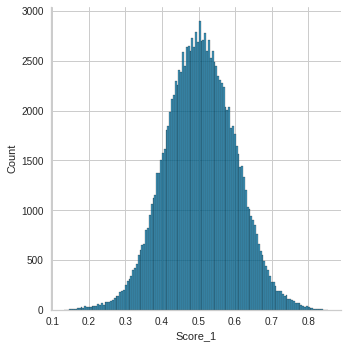

In [109]:
df_test_after_AutoML = df_test.copy()

df_test_after_AutoML['pred'] = predictions['Score_1']

_ = sns.displot(predictions['Score_1'])

#### 최종 제출 파일

In [118]:
final_sub_after_AutoML = df_test_after_AutoML[['ID', 'pred']].copy()

final_sub_after_AutoML.to_csv('submission_total_0313.csv', index=False)

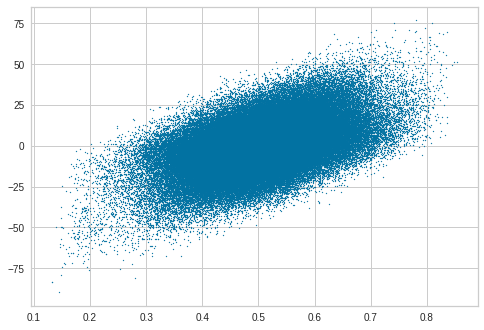

In [111]:
plt.scatter(final_sub_after_AutoML['pred'],df_test['EMDiff'],s=1)

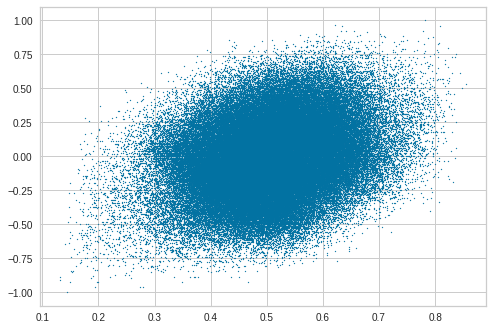

In [112]:
plt.scatter(final_sub_after_AutoML['pred'],df_test['WinRatioDiff'],s=1)

In [113]:
final_sub_after_AutoML

,ID,pred
0,2023_1101_1102,0.6398
1,2023_1101_1103,0.5567
2,2023_1101_1104,0.5983
3,2023_1101_1105,0.6069
4,2023_1101_1106,0.6537
...,...,...
130678,2023_3474_3476,0.4236
130679,2023_3474_3477,0.4381
130680,2023_3475_3476,0.5937
130681,2023_3475_3477,0.5766


In [114]:
final_sub_after_AutoML[final_sub_after_AutoML['pred'] < 0.5]

,ID,pred
8,2023_1101_1111,0.4709
13,2023_1101_1116,0.4985
16,2023_1101_1120,0.4910
19,2023_1101_1124,0.4497
33,2023_1101_1140,0.4953
...,...,...
130675,2023_3473_3476,0.4117
130676,2023_3473_3477,0.4167
130677,2023_3474_3475,0.3862
130678,2023_3474_3476,0.4236


In [115]:
# #모델 불러오기

# load_model = load_model("/content/Model_test_2023-03-05")

# predictions = predict_model(load_model,
#                             data=test_df)

### Test : 각년도별로 test

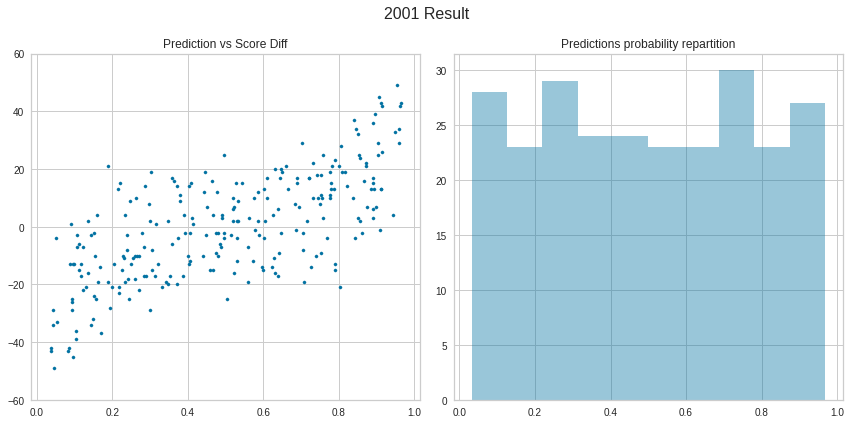

2001 Score :  0.1715437374847114


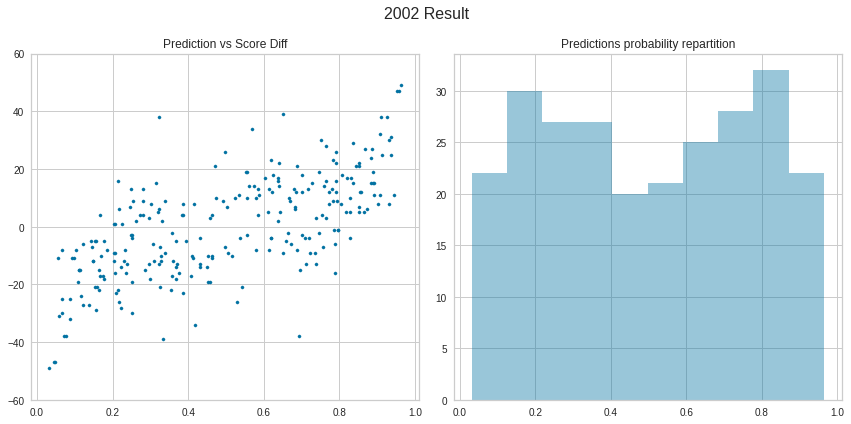

2002 Score :  0.17276097303119667


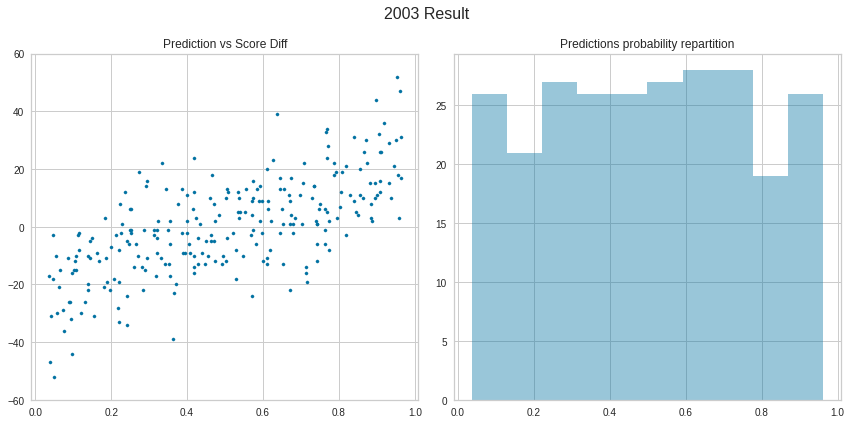

2003 Score :  0.15249793928331504


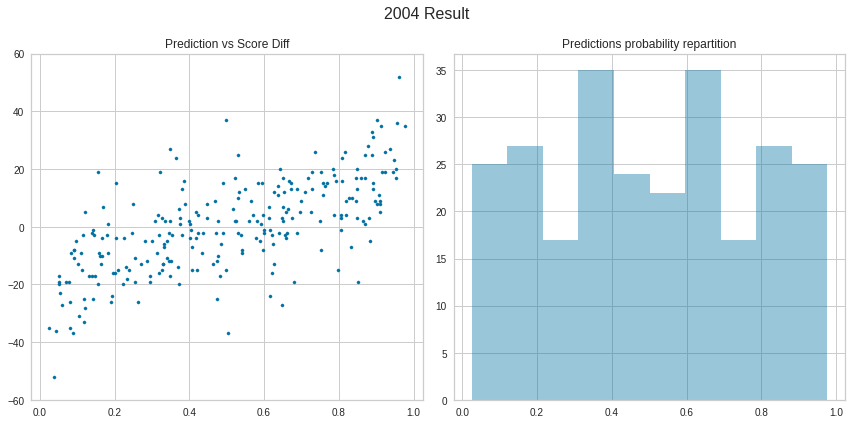

2004 Score :  0.15911436737916285


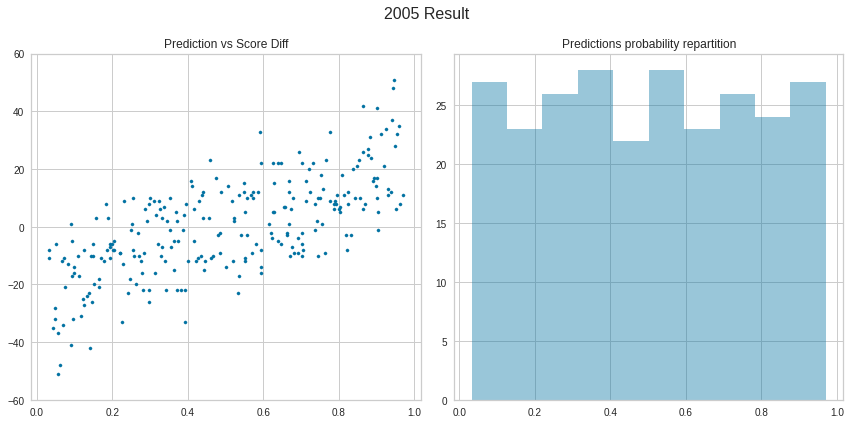

2005 Score :  0.17192929625019593


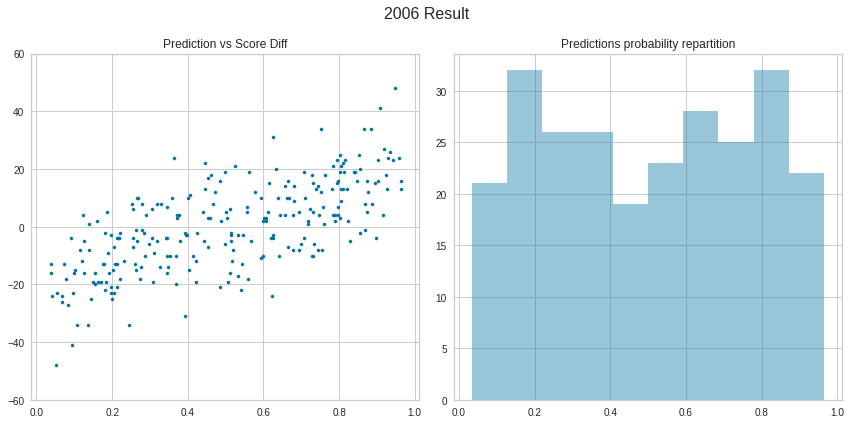

2006 Score :  0.16382470314937092


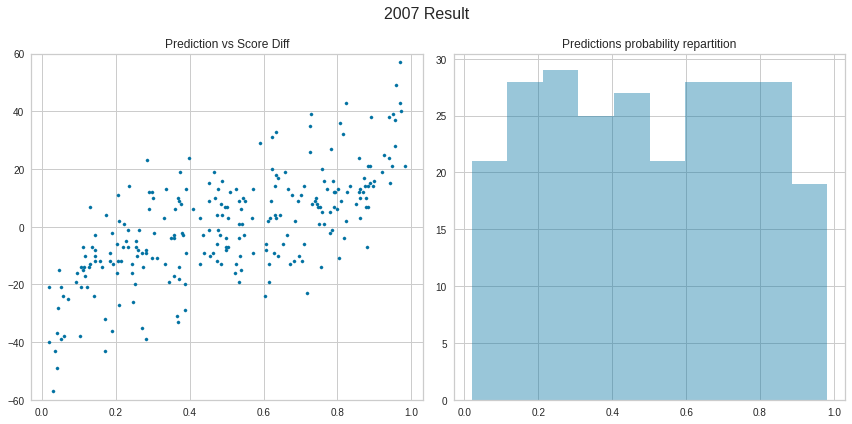

2007 Score :  0.16057074160767804


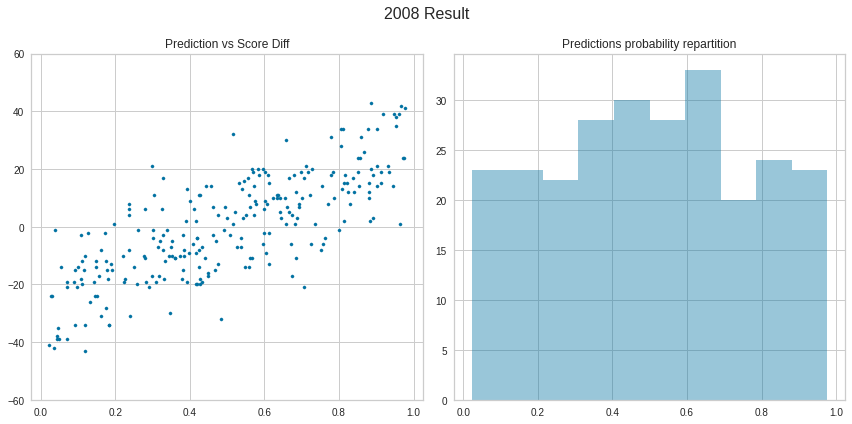

2008 Score :  0.14002346455785264


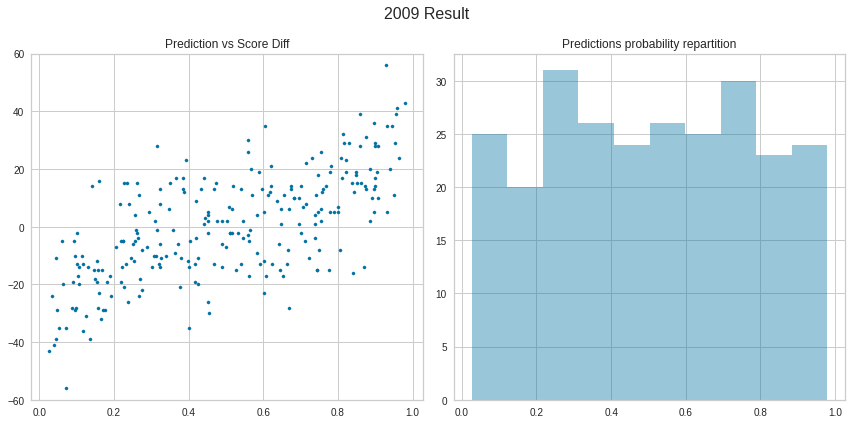

2009 Score :  0.16493466750787894


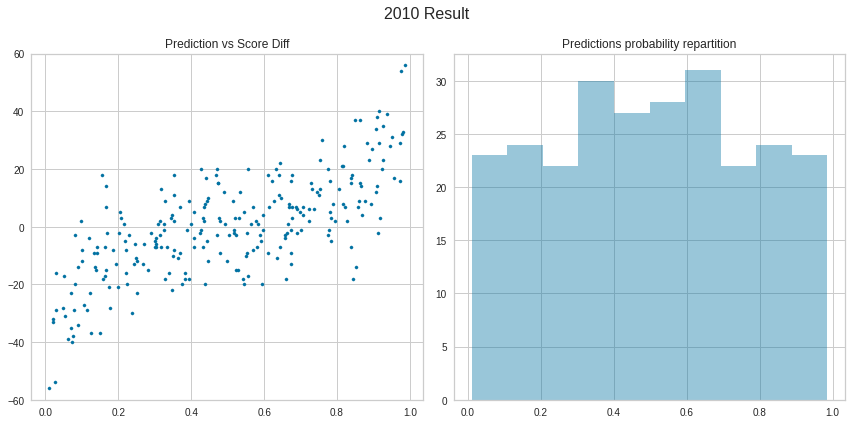

2010 Score :  0.17059187816626473


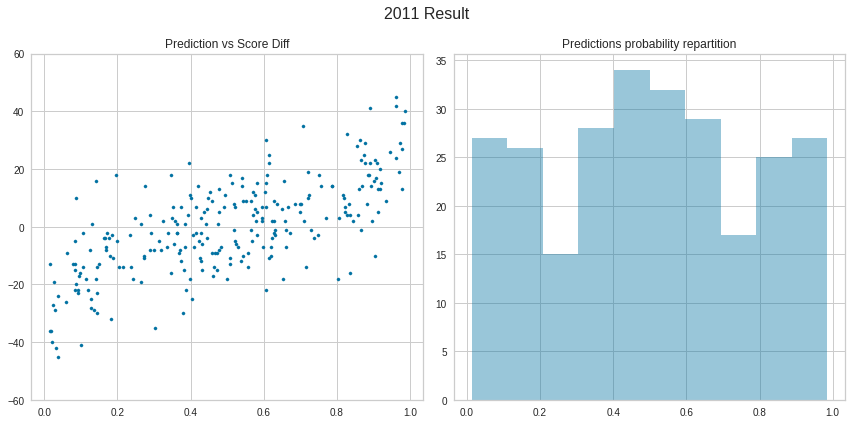

2011 Score :  0.16604637283173543


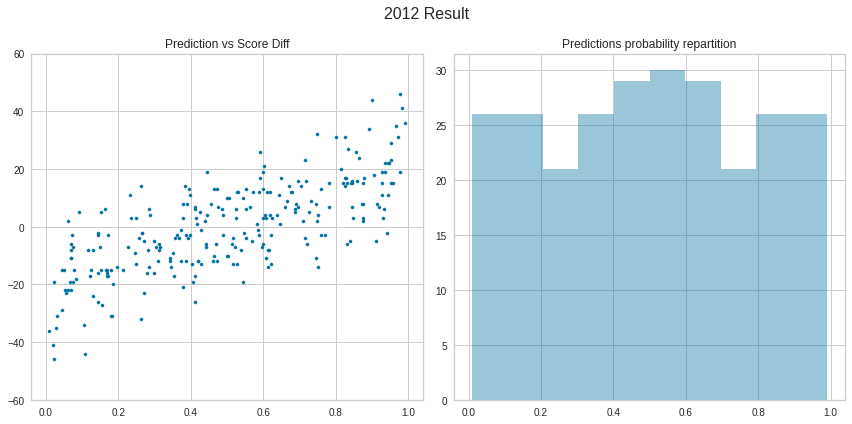

2012 Score :  0.15857336915761167


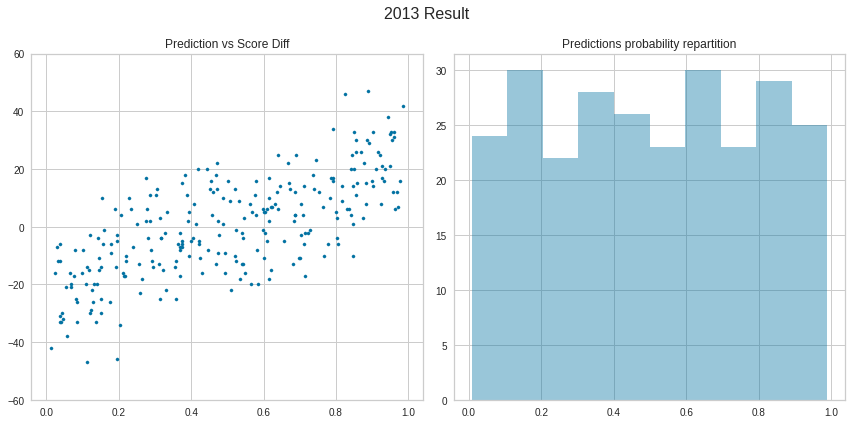

2013 Score :  0.15835569498876645


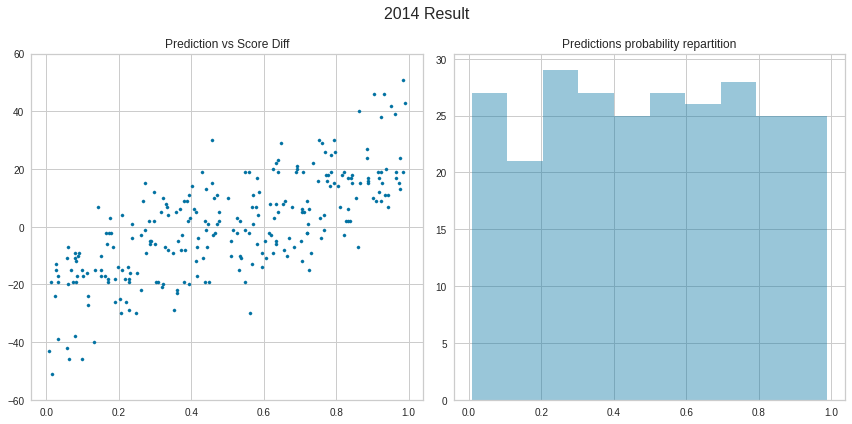

2014 Score :  0.15844930626888015


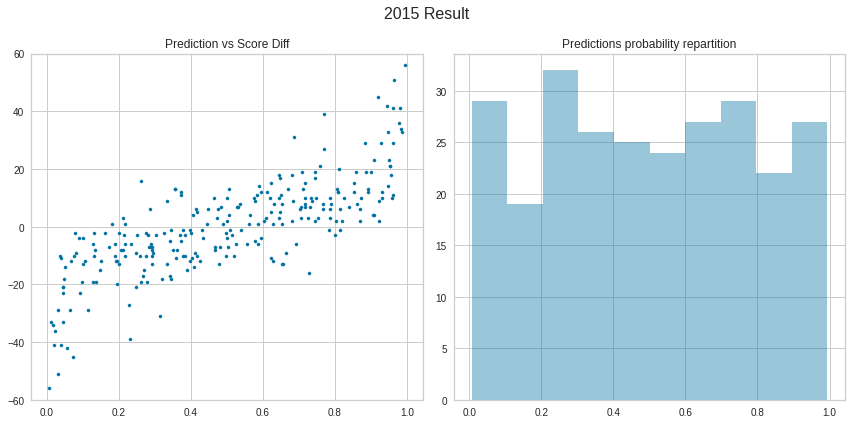

2015 Score :  0.12419117560582342


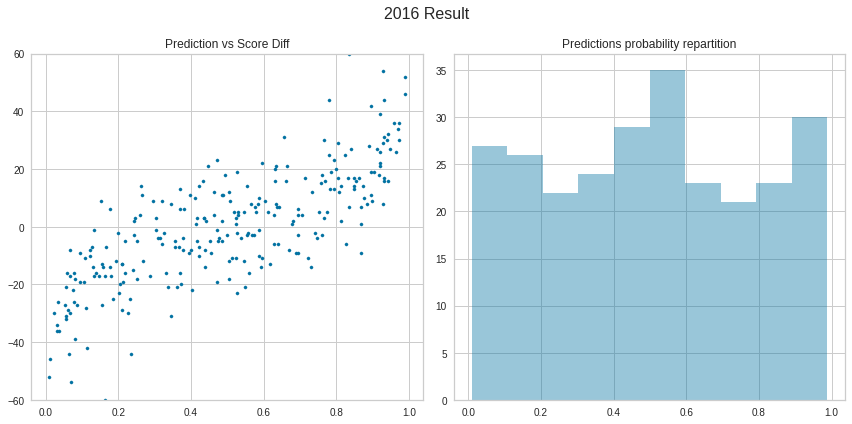

2016 Score :  0.14878556052836434


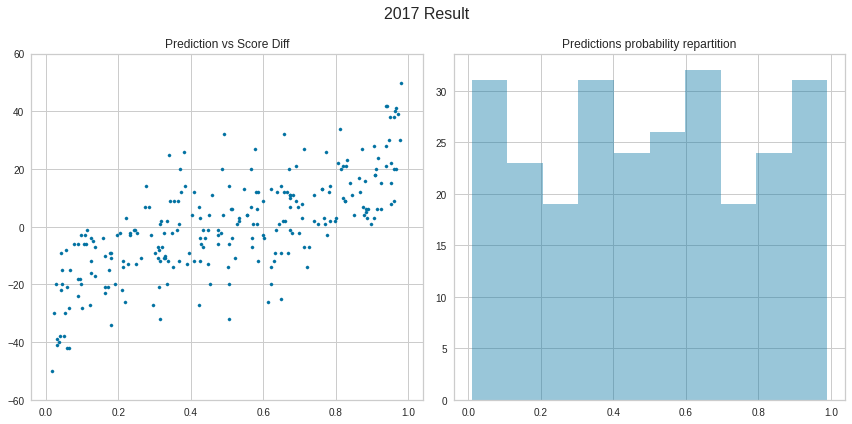

2017 Score :  0.13199900440185097


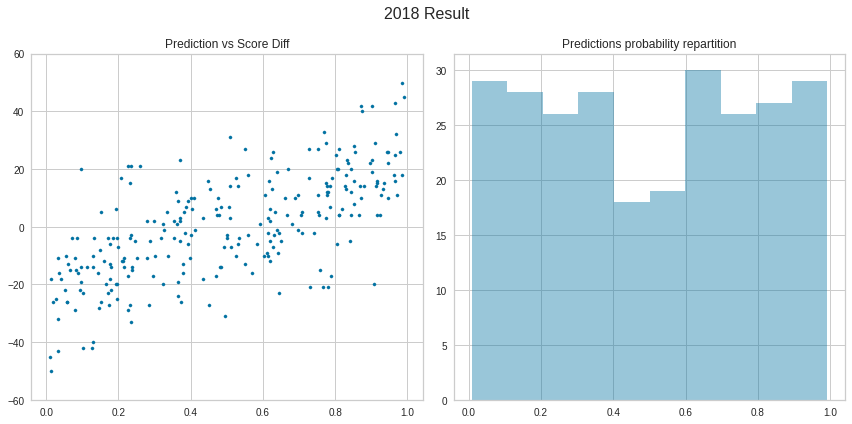

2018 Score :  0.1563118831392608


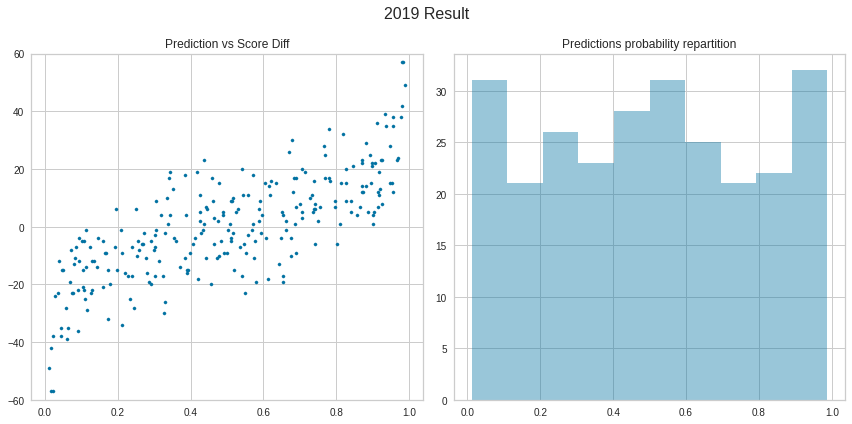

2019 Score :  0.13020269498480389


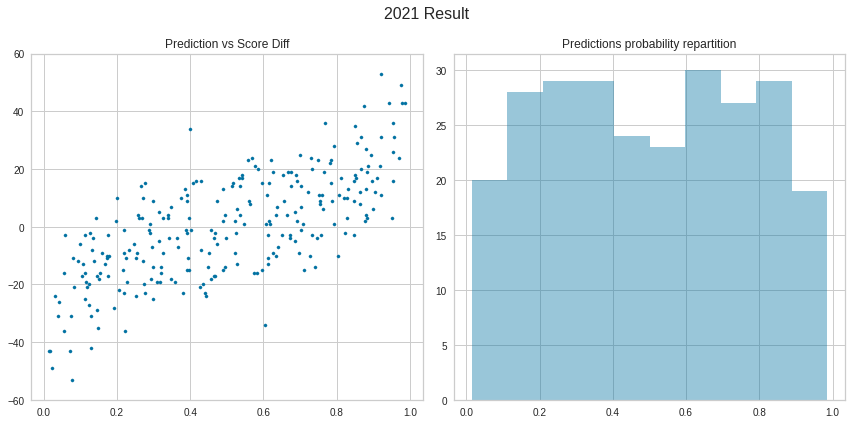

2021 Score :  0.15933409267210147


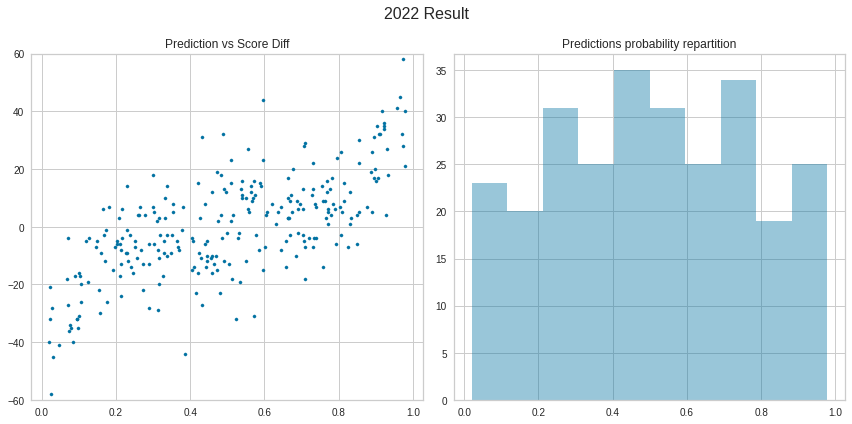

2022 Score :  0.16707394361612327


In [116]:
for year in df['Season'].unique():

  df_val = df[df['Season'] == year]

  df_val = df_val.reset_index(drop=True)

  prediction = prep_pipe.predict_proba(df_val[features])

  i, j = [], []
  for row in prediction:
    i.append(row[0])
    j.append(row[1])

  len(i), len(j)

  df_val['pred'] = j

  df_val['WinA_pred'] = prep_pipe.predict(df_val[features])
  
  #plt.figure(figsize=(12, 6))
  fig, ax = plt.subplots(1, 2,figsize = [12, 6])
  ax[0].set_ylim(-60, 60)
  ax[0].scatter(df_val['pred'], df_val['ScoreDiff'].values, s=10)
  ax[0].set_title('Prediction vs Score Diff')

  ax[1].hist(df_val['pred'], bins = 10, alpha = 0.4)
  ax[1].set_title('Predictions probability repartition')

  fig.suptitle(f'{year} Result', fontsize=16) # figure 제목

  fig.tight_layout() # 사용하면 플롯간 여백을 조정해준다. 
  plt.show()
  
  print(f'{year} Score : ', brier_score_loss(df_val['WinA'], df_val['pred']))

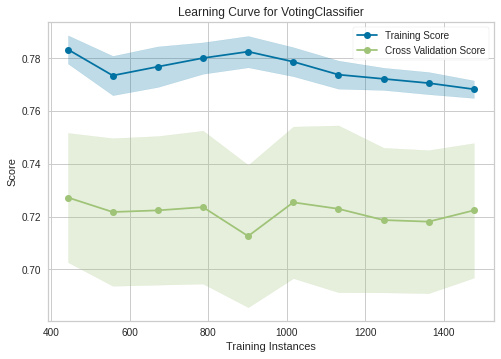

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [117]:
plot_model(final_model_custom, plot = 'learning', use_train_data = True)

# Woman / Man 분화

In [119]:
train_man = df[df['Season'] >= 2003][df[df['Season'] >= 2003]['TeamIdA'].astype('str').str.contains('^1',regex= True)]

train_woman = df[df['Season'] >= 2013][df[df['Season'] >= 2013]['TeamIdA'].astype('str').str.contains('^3',regex= True)]

test_man = df_test[df_test['TeamIdA'].astype('str').str.contains('^1',regex= True)]

test_woman = df_test[df_test['TeamIdA'].astype('str').str.contains('^3',regex= True)]

In [120]:
train_df_man = pd.concat([train_man[features], train_man['WinA']],axis=1)

test_df_man = test_man[features]

In [121]:
train_df_man.corr()

,SeedDiff,WinRatioDiff,GapAvgDiff,FGDiff,FG3Diff,FTDiff,TOmarginDiff,WinRatio_3yearsDiff,GapAvg_3yearsDiff,LuckyDiff,TourneyY_3yearsA,TourneyY_3yearsB,TourneyY_3yearsDiff,OEDiff,DEDiff,EMDiff,EWPDiff,TopClassY_3yearsDiff,WinA
SeedDiff,1.000000,-0.631131,-0.691713,-0.332609,-0.183612,-0.077331,0.179928,-0.615986,-0.679798,-0.143683,-0.405974,0.405974,-0.568389,-0.555068,0.402666,-0.679610,-0.654694,-0.506934,-0.479610
WinRatioDiff,-0.631131,1.000000,0.847839,0.492138,0.255951,0.111277,-0.258470,0.694894,0.654522,0.472301,0.256325,-0.256325,0.358872,0.645779,-0.566882,0.855930,0.955108,0.405774,0.333528
GapAvgDiff,-0.691713,0.847839,1.000000,0.581066,0.336630,0.117342,-0.309580,0.715286,0.800933,0.038198,0.326467,-0.326467,0.457075,0.751043,-0.652563,0.990991,0.931529,0.467337,0.406542
FGDiff,-0.332609,0.492138,0.581066,1.000000,0.533678,0.165784,0.152726,0.373750,0.419553,0.028940,0.156780,-0.156780,0.219502,0.714430,-0.064133,0.573587,0.538442,0.293139,0.195544
FG3Diff,-0.183612,0.255951,0.336630,0.533678,1.000000,0.283380,0.076919,0.173402,0.214901,-0.004482,0.078420,-0.078420,0.109794,0.576676,0.130618,0.342050,0.286597,0.133908,0.079824
FTDiff,-0.077331,0.111277,0.117342,0.165784,0.283380,1.000000,-0.011034,0.077231,0.084447,0.011728,0.036865,-0.036865,0.051614,0.361353,0.207448,0.131047,0.120004,0.054016,0.051957
TOmarginDiff,0.179928,-0.258470,-0.309580,0.152726,0.076919,-0.011034,1.000000,-0.203447,-0.219964,-0.015203,-0.070285,0.070285,-0.098403,-0.149848,0.290842,-0.304245,-0.282787,-0.084663,-0.171951
WinRatio_3yearsDiff,-0.615986,0.694894,0.715286,0.373750,0.173402,0.077231,-0.203447,1.000000,0.935037,0.164767,0.534355,-0.534355,0.748132,0.546726,-0.462872,0.713331,0.718629,0.473920,0.359065
GapAvg_3yearsDiff,-0.679798,0.654522,0.800933,0.419553,0.214901,0.084447,-0.219964,0.935037,1.000000,-0.000931,0.523459,-0.523459,0.732877,0.615040,-0.500261,0.788905,0.729354,0.511583,0.396183
LuckyDiff,-0.143683,0.472301,0.038198,0.028940,-0.004482,0.011728,-0.015203,0.164767,-0.000931,1.000000,-0.009162,0.009162,-0.012827,0.065298,0.019737,0.035451,0.189966,0.089651,0.008219


In [123]:
train_df_woman = pd.concat([train_woman[features], train_woman['WinA']],axis=1)

test_df_woman = test_woman[features]

In [124]:
train_df_woman.corr()

,SeedDiff,WinRatioDiff,GapAvgDiff,FGDiff,FG3Diff,FTDiff,TOmarginDiff,WinRatio_3yearsDiff,GapAvg_3yearsDiff,LuckyDiff,TourneyY_3yearsA,TourneyY_3yearsB,TourneyY_3yearsDiff,OEDiff,DEDiff,EMDiff,EWPDiff,TopClassY_3yearsDiff,WinA
SeedDiff,1.000000,-0.546901,-0.605142,-0.602672,-0.357110,-0.157019,0.103322,-0.585135,-0.635970,-0.061359,-0.438243,0.438243,-0.645258,-0.592653,0.334252,-0.587219,-0.559546,-0.608824,-0.615355
WinRatioDiff,-0.546901,1.000000,0.855364,0.660198,0.469344,0.179242,-0.323102,0.821890,0.765894,0.317297,0.287085,-0.287085,0.422696,0.735738,-0.660815,0.860187,0.977396,0.637481,0.369006
GapAvgDiff,-0.605142,0.855364,1.000000,0.782387,0.507112,0.207710,-0.404001,0.798741,0.904474,-0.062370,0.327463,-0.327463,0.482148,0.867078,-0.746369,0.996448,0.910440,0.688009,0.474219
FGDiff,-0.602672,0.660198,0.782387,1.000000,0.641365,0.333034,-0.079839,0.666986,0.748259,-0.043618,0.319575,-0.319575,0.470535,0.872164,-0.326967,0.776160,0.701700,0.593394,0.437713
FG3Diff,-0.357110,0.469344,0.507112,0.641365,1.000000,0.401925,0.012302,0.431151,0.438502,0.003434,0.187467,-0.187467,0.276022,0.662116,-0.095419,0.507696,0.491170,0.360510,0.258648
FTDiff,-0.157019,0.179242,0.207710,0.333034,0.401925,1.000000,0.012792,0.171544,0.195503,0.042510,0.035548,-0.035548,0.052339,0.433578,0.178275,0.203987,0.178393,0.111654,0.117513
TOmarginDiff,0.103322,-0.323102,-0.404001,-0.079839,0.012302,0.012792,1.000000,-0.260700,-0.317508,0.044048,-0.078283,0.078283,-0.115262,-0.275616,0.384556,-0.395344,-0.348474,-0.208671,-0.111453
WinRatio_3yearsDiff,-0.585135,0.821890,0.798741,0.666986,0.431151,0.171544,-0.260700,1.000000,0.913438,0.101275,0.454366,-0.454366,0.668997,0.716727,-0.574815,0.801181,0.838873,0.674564,0.424785
GapAvg_3yearsDiff,-0.635970,0.765894,0.904474,0.748259,0.438502,0.195503,-0.317508,0.913438,1.000000,-0.048961,0.425080,-0.425080,0.625877,0.793290,-0.662777,0.900938,0.813674,0.711753,0.490724
LuckyDiff,-0.061359,0.317297,-0.062370,-0.043618,0.003434,0.042510,0.044048,0.101275,-0.048961,1.000000,-0.017597,0.017597,-0.025909,-0.044187,0.062519,-0.063844,0.109632,0.058056,-0.058960


## Man

In [125]:
from pycaret.classification import *

pd.options.display.float_format = None

clf_test_2 = setup(data=train_df_man,   # df 설정
                   target='WinA', # Target 설정
                   train_size= 0.7, # size 설정
                   fold=10,
                   normalize = True,
                   transformation = False,
                   pca = False,
                   feature_selection = False,
                   session_id = 4629,
                   silent=True,
                   #remove_outliers = True,
                   #use_gpu = True,
                   #ordinal_features = {'key' : [i for i in range(12)]}'# Fold 설정
                   )

#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

from sklearn.metrics import brier_score_loss

add_metric('Brier', 'Brier', brier_score_loss, greater_is_better=False, target="pred_proba")

,Description,Value
0,session_id,4629
1,Target,WinA
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2496, 19)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', '

Name                                                             Brier
Display Name                                                     Brier
Score Function           <function brier_score_loss at 0x7f1f163121f0>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: Brier, dtype: object

In [126]:
#Brier score가 높은 모델 3개를 앙상블 (제외된 2개의 모델은 Brier score를 구할 수 없어서 제외함)
#Brier score가 지나치게 높게 나오는데 CV에 따른 차이로 생각됨.

custom_model = compare_models(fold = 10, 
                              sort = 'Brier', 
                              n_select = 3, 
                              exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,TT (Sec)
lr,Logistic Regression,0.6989,0.7854,0.6937,0.7007,0.6952,0.3977,0.4002,0.5523,0.1885,0.392
lda,Linear Discriminant Analysis,0.6989,0.7858,0.6902,0.7014,0.6940,0.3977,0.3999,0.5527,0.1887,0.010
catboost,CatBoost Classifier,0.6932,0.7676,0.6683,0.7019,0.6836,0.3861,0.3878,0.5735,0.1968,2.814
et,Extra Trees Classifier,0.6904,0.7586,0.6509,0.7036,0.6751,0.3802,0.3823,0.5764,0.1990,0.145
rf,Random Forest Classifier,0.6646,0.7558,0.6370,0.6711,0.6527,0.3287,0.3300,0.5816,0.2002,0.249
gbc,Gradient Boosting Classifier,0.6749,0.7562,0.6509,0.6798,0.6643,0.3495,0.3507,0.5830,0.2008,0.294
lightgbm,Light Gradient Boosting Machine,0.6812,0.7497,0.6568,0.6872,0.6711,0.3621,0.3629,0.6545,0.2176,0.200
knn,K Neighbors Classifier,0.6532,0.7096,0.6497,0.6505,0.6495,0.3062,0.3068,1.7625,0.2261,0.024
xgboost,Extreme Gradient Boosting,0.6818,0.7540,0.6661,0.6843,0.6748,0.3634,0.3638,0.7378,0.2296,0.218
ada,Ada Boost Classifier,0.6640,0.7384,0.6347,0.6718,0.6519,0.3276,0.3289,0.6673,0.2379,0.100


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4629, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), <catboost.core.CatBoostClassifier object at 0x7f1f61970be0>]
INFO:logs:compare_models() succesfully completed......................................


In [127]:
# 가장 좋은 모델에 대해 튜닝

tuned_top = [tune_model(i, optimize = 'Brier') for i in custom_model]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.6971,0.7945,0.6512,0.7089,0.6788,0.3933,0.3945,0.5534,0.1881
1,0.6914,0.7642,0.6512,0.7000,0.6747,0.3819,0.3829,0.5798,0.1973
2,0.6457,0.7454,0.6437,0.6437,0.6437,0.2914,0.2914,0.5854,0.2019
3,0.6800,0.7938,0.7011,0.6703,0.6854,0.3601,0.3605,0.5413,0.1839
4,0.6629,0.7350,0.6322,0.6707,0.6509,0.3255,0.3260,0.5994,0.2078
5,0.7257,0.7808,0.6437,0.7671,0.7000,0.4509,0.4568,0.5667,0.1925
6,0.6457,0.7454,0.6437,0.6437,0.6437,0.2914,0.2914,0.5930,0.2048
7,0.6264,0.7238,0.6279,0.6207,0.6243,0.2529,0.2529,0.6121,0.2127
8,0.7701,0.8568,0.6977,0.8108,0.7500,0.5394,0.5447,0.4958,0.1621


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 5
INFO:logs:<catboost.core.CatBoostClassifier object at 0x7f1e2873c310>
INFO:logs:tune_model() succesfully completed......................................


In [128]:
# Brier score

blended_custom = blend_models(estimator_list = tuned_top,
                              fold = 10,
                              optimize = 'Brier')

pred_holdout_custom = predict_model(blended_custom)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.7200,0.8076,0.6628,0.7403,0.6994,0.4388,0.4412,0.5266,0.1788
1,0.7029,0.7757,0.6512,0.7179,0.6829,0.4046,0.4063,0.5677,0.1929
2,0.6686,0.7554,0.6667,0.6667,0.6667,0.3371,0.3371,0.5817,0.2005
3,0.6800,0.8008,0.6897,0.6742,0.6818,0.3601,0.3602,0.5265,0.1794
4,0.6743,0.7433,0.6552,0.6786,0.6667,0.3484,0.3486,0.5951,0.2061
5,0.7371,0.7858,0.6667,0.7733,0.7160,0.4739,0.4784,0.5566,0.1890
6,0.6800,0.7586,0.7126,0.6667,0.6889,0.3602,0.3611,0.5822,0.2006
7,0.6437,0.7340,0.6395,0.6395,0.6395,0.2873,0.2873,0.6084,0.2113
8,0.7644,0.8623,0.6860,0.8082,0.7421,0.5279,0.5339,0.4792,0.1566


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 6
INFO:logs:VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.356, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         prio

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
0,Voting Classifier,0.7103,0.7843,0.7285,0.7117,0.72,0.4199,0.4201,0.556,0.189


In [129]:
#최종 모델
final_model_custom = finalize_model(blended_custom)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.356, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                               

In [130]:
#
import datetime

now = datetime.datetime.now()

save_model(final_model_custom, f"/content/Model_MAN_test_{datetime.datetime.now()}")

prep_pipe = get_config("prep_pipe")

prep_pipe.steps.append(['trained_model', final_model_custom])

man_predictions = predict_model(prep_pipe,
                                data=test_df_man,
                                raw_score=True)

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.356, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                                           

Transformation Pipeline and Model Successfully Saved


INFO:logs:get_config() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                                  random_state=4629,
                                              

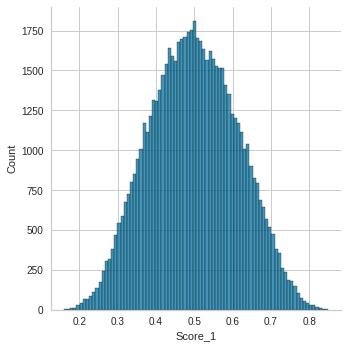

In [131]:
test_df_man_after_AutoML = test_df_man.copy()

test_df_man_after_AutoML['pred'] = man_predictions['Score_1']

_ = sns.displot(man_predictions['Score_1'])

In [132]:
def visualize_result(df,prep_pipe, types = None):

  if types == 'man':
    df = df[df['Season'] >= 2003][df[df['Season'] >= 2003]['TeamIdA'].astype('str').str.contains('^1',regex= True)]

  elif types == 'woman':
    df = df[df['Season'] >= 2013][df[df['Season'] >= 2013]['TeamIdA'].astype('str').str.contains('^3',regex= True)]

  else:
    pass

  for year in df['Season'].unique():      
      
    df_val = df[df['Season'] == year]

    df_val = df_val.reset_index(drop=True)

    prediction = prep_pipe.predict_proba(df_val[features])

    i, j = [], []
    for row in prediction:
      i.append(row[0])
      j.append(row[1])

    len(i), len(j)

    df_val['pred'] = j

    df_val['WinA_pred'] = prep_pipe.predict(df_val[features])
    
    #plt.figure(figsize=(12, 6))
    fig, ax = plt.subplots(1, 2,figsize = [12, 6])
    ax[0].set_ylim(-60, 60)
    ax[0].scatter(df_val['pred'], df_val['ScoreDiff'].values, s=10)
    ax[0].set_title('Prediction vs Score Diff')

    ax[1].hist(df_val['pred'], bins = 10, alpha = 0.4)
    ax[1].set_title('Predictions probability repartition')

    fig.suptitle(f'{year} Result', fontsize=16) # figure 제목

    fig.tight_layout() # 사용하면 플롯간 여백을 조정해준다. 
    plt.show()
    
    print(f'{year} Score : ', brier_score_loss(df_val['WinA'], df_val['pred']))

## woman

In [133]:
#https://pycaret.readthedocs.io/en/latest/api/regression.html

from pycaret.classification import *

clf_test_3 = setup(data=train_df_woman,   # df 설정
                   target='WinA', # Target 설정
                   train_size= 0.7, # size 설정
                   fold=10,
                   normalize = True,
                   transformation = False,
                   pca = False,
                   feature_selection = False,
                   session_id = 4629,
                   silent=True,
                   #remove_outliers = True,
                   #use_gpu = True,
                   #ordinal_features = {'key' : [i for i in range(12)]}'# Fold 설정
                   )

#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

from sklearn.metrics import brier_score_loss

add_metric('Brier', 'Brier', brier_score_loss, greater_is_better=False, target="pred_proba")

,Description,Value
0,session_id,4629
1,Target,WinA
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1142, 19)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', '

Name                                                             Brier
Display Name                                                     Brier
Score Function           <function brier_score_loss at 0x7f1f163121f0>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: Brier, dtype: object

In [134]:
#Brier score가 높은 모델 3개를 앙상블 (제외된 2개의 모델은 Brier score를 구할 수 없어서 제외함)

custom_model = compare_models(fold = 10, 
                              sort = 'Brier', 
                              n_select = 3, 
                              exclude=['svm','ridge','catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,TT (Sec)
lr,Logistic Regression,0.7510,0.8548,0.7545,0.7527,0.7516,0.5020,0.5046,0.4671,0.1566,0.013
lda,Linear Discriminant Analysis,0.7535,0.8538,0.7495,0.7584,0.7524,0.5070,0.5089,0.4701,0.1576,0.008
et,Extra Trees Classifier,0.7447,0.8375,0.7546,0.7402,0.7465,0.4895,0.4907,0.4824,0.1632,0.125
rf,Random Forest Classifier,0.7535,0.8344,0.7470,0.7586,0.7511,0.5070,0.5091,0.4917,0.1653,0.147
gbc,Gradient Boosting Classifier,0.7309,0.8258,0.7320,0.7311,0.7297,0.4619,0.4641,0.5113,0.1750,0.137
knn,K Neighbors Classifier,0.7221,0.8020,0.7269,0.7215,0.7224,0.4444,0.4466,1.3957,0.1829,0.019
lightgbm,Light Gradient Boosting Machine,0.7398,0.8230,0.7446,0.7373,0.7404,0.4795,0.4803,0.6460,0.1972,0.205
xgboost,Extreme Gradient Boosting,0.7222,0.8176,0.7321,0.7168,0.7233,0.4445,0.4459,0.6890,0.2041,0.112
ada,Ada Boost Classifier,0.7197,0.8241,0.7219,0.7198,0.7194,0.4393,0.4410,0.5978,0.2056,0.076
nb,Naive Bayes,0.7172,0.8114,0.7169,0.7197,0.7161,0.4344,0.4371,1.3737,0.2420,0.012


INFO:logs:create_model_container: 13
INFO:logs:master_model_container: 13
INFO:logs:display_container: 2
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4629, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimat

In [135]:
# 가장 좋은 모델에 대해 튜닝

tuned_top = [tune_model(i, optimize = 'Brier') for i in custom_model]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.8125,0.8769,0.8250,0.8049,0.8148,0.6250,0.6252,0.4461,0.1473
1,0.7875,0.8825,0.7750,0.7949,0.7848,0.5750,0.5752,0.4458,0.1468
2,0.7750,0.8150,0.8250,0.7500,0.7857,0.5500,0.5528,0.5143,0.1772
3,0.7625,0.8756,0.7250,0.7838,0.7532,0.5250,0.5265,0.4477,0.1475
4,0.7250,0.8038,0.7000,0.7368,0.7179,0.4500,0.4506,0.5203,0.1799
5,0.7625,0.8481,0.7250,0.7838,0.7532,0.5250,0.5265,0.4796,0.1603
6,0.8125,0.9050,0.8250,0.8049,0.8148,0.6250,0.6252,0.4068,0.1317
7,0.7625,0.8581,0.8000,0.7442,0.7711,0.5250,0.5265,0.4743,0.1573
8,0.7250,0.8506,0.6250,0.7812,0.6944,0.4500,0.4593,0.4818,0.1615


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 5
INFO:logs:ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                     criterion='gini', max_depth=4, max_features=1.0,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.001, min_impurity_split=None,
                     min_samples_leaf=6, min_samples_split=10,
                     min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                     oob_score=False, random_state=4629, verbose=0,
                     warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [136]:
# Brier score

blended_custom = blend_models(estimator_list = tuned_top,
                              fold = 10,
                              optimize = 'Brier')

pred_holdout_custom = predict_model(blended_custom)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.7875,0.8762,0.8000,0.7805,0.7901,0.5750,0.5752,0.4446,0.1473
1,0.7500,0.8712,0.7500,0.7500,0.7500,0.5000,0.5000,0.4508,0.1498
2,0.6625,0.7869,0.7500,0.6383,0.6897,0.3250,0.3301,0.5453,0.1914
3,0.7875,0.8619,0.7250,0.8286,0.7733,0.5750,0.5795,0.4507,0.1507
4,0.7125,0.8100,0.7000,0.7179,0.7089,0.4250,0.4251,0.5209,0.1799
5,0.7375,0.8569,0.7000,0.7568,0.7273,0.4750,0.4763,0.4641,0.1543
6,0.8000,0.9069,0.8250,0.7857,0.8049,0.6000,0.6008,0.3889,0.1260
7,0.7625,0.8619,0.8000,0.7442,0.7711,0.5250,0.5265,0.4660,0.1543
8,0.7250,0.8494,0.6250,0.7812,0.6944,0.4500,0.4593,0.4813,0.1614


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 6
INFO:logs:VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.356, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         prio

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
0,Voting Classifier,0.8076,0.9089,0.7849,0.8232,0.8036,0.6152,0.6159,0.3931,0.1265


In [137]:
#최종 모델
final_model_custom = finalize_model(blended_custom)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.356, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                               

In [138]:
#
import datetime

now = datetime.datetime.now()

save_model(final_model_custom, f"/content/Model_WOMAN_test_{datetime.datetime.now()}")

prep_pipe = get_config("prep_pipe")

prep_pipe.steps.append(['trained_model', final_model_custom])

woman_predictions = predict_model(prep_pipe,
                                data=test_df_woman,
                                raw_score=True)

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.356, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                                           

Transformation Pipeline and Model Successfully Saved


INFO:logs:get_config(variable=prep_pipe)
INFO:logs:Global variable: prep_pipe returned as Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', 'passthrough'), ('cluste

In [139]:
train_df_woman['WinA'].value_counts()

1    571
0    571
Name: WinA, dtype: int64

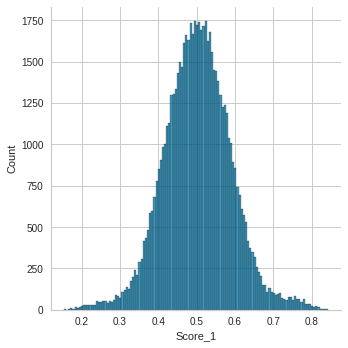

In [140]:
test_df_woman_after_AutoML = test_df_woman.copy()

test_df_woman_after_AutoML['pred'] = woman_predictions['Score_1']

_ = sns.displot(woman_predictions['Score_1'])

## 통합

In [141]:
test_df_2_after_AutoML = pd.concat([test_df_man_after_AutoML, test_df_woman_after_AutoML])

test_df_2_after_AutoML = pd.concat([test_df_2_after_AutoML, df_test['ID']],axis=1)

final_sub2 = test_df_2_after_AutoML[['ID','pred']]

In [147]:
final_sub2.to_csv('submission_cross_0313.csv', index=False)

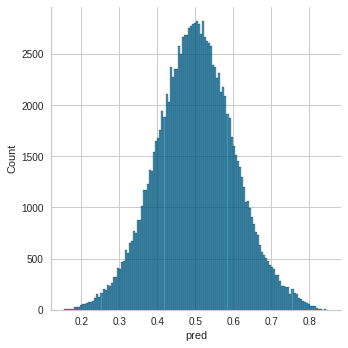

In [148]:
_ = sns.displot(test_df_2_after_AutoML['pred'])

In [150]:
test_woman

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,NumWinsA,NumLossesA,GapWinsA,...,AdjEWPDiff,OEDiff,DEDiff,EMDiff,EWPDiff,PossessionDiff,LuckyA,LuckyB,LuckyDiff,pred
65703,2023_3101_3102,0.5,2023,3101,3102,1,1,9.0,14.0,18.222222,...,0.050766,9.750616,4.065604,5.685011,0.037900,-1.575268,-0.072647,-0.026052,-0.046595,0.519751
65704,2023_3101_3103,0.5,2023,3101,3103,1,1,9.0,14.0,18.222222,...,-0.059697,8.774130,5.815682,2.958448,-0.088398,-3.400904,-0.072647,0.012868,-0.085515,0.608644
65705,2023_3101_3104,0.5,2023,3101,3104,1,1,9.0,14.0,18.222222,...,-0.206267,-0.699974,14.013751,-14.713725,-0.246019,-0.768186,-0.072647,0.030770,-0.103417,0.474214
65706,2023_3101_3105,0.5,2023,3101,3105,1,1,9.0,14.0,18.222222,...,-0.003531,19.498566,10.798732,8.699834,-0.037266,-1.317220,-0.072647,0.018782,-0.091430,0.670301
65707,2023_3101_3106,0.5,2023,3101,3106,1,1,9.0,14.0,18.222222,...,0.056480,15.609819,-0.337940,15.947758,0.010504,-3.871588,-0.072647,0.066553,-0.139200,0.698353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476,1,1,5.0,18.0,10.200000,...,-0.119614,-7.480114,1.022188,-8.502302,-0.123022,3.885720,0.014523,-0.056659,0.071183,0.408194
130679,2023_3474_3477,0.5,2023,3474,3477,1,1,5.0,18.0,10.200000,...,-0.191399,-9.127441,3.994981,-13.122422,-0.207967,-2.590587,0.014523,0.012242,0.002281,0.404845
130680,2023_3475_3476,0.5,2023,3475,3476,1,1,8.0,16.0,13.875000,...,0.080813,-3.124819,-9.681966,6.557146,0.074655,6.703877,-0.067212,-0.056659,-0.010553,0.589211
130681,2023_3475_3477,0.5,2023,3475,3477,1,1,8.0,16.0,13.875000,...,0.009029,-4.772146,-6.709173,1.937027,-0.010289,0.227569,-0.067212,0.012242,-0.079454,0.585441


# Loss function 조합